# Using a Custom Convolutional Network to classify Intel Image Dataset

## Environment prep and data unzipping (This section needed for Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  1 18:38:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir /data/

In [ ]:
!unzip -q '/content/drive/My Drive/Projects/Kaggle Intel Dataset/kaggle intel' -d /data/

In [ ]:
%cd '/data/'

/data


In [ ]:
!ls

seg_pred  seg_test  seg_train


## Dataset, Dataloader classes and Transform methods

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import time
from time import sleep
from tqdm import tqdm, trange
from prettytable import PrettyTable




import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
subdir = ['buildings','forest','glacier', 'mountain', 'sea', 'street']

Custom Dataset Class for Appliances Dataset

In [ ]:
# Dataset Class

class IntelData(Dataset):
  """ Appliance Dataset Class"""
  def __init__(self, root_dir, transform=None):
    """
    Arguments:
      csv_file (string): Full path to csv file
      root_dir (string): Full path before Data Folder
      transform (callable, optional): transforms to be applied on images
    """
    self.root_dir = root_dir
    self.file_df = pd.DataFrame(columns=['filepath','label','img_size'])
    
    # populating dataframe with paths and labels
    filepaths = []
    labels = []
    iSize = []
    for s in subdir:
      rootp = self.root_dir + s
      for root, dirs, files in os.walk(rootp, topdown=False):
        for name in files:
          fPath = os.path.join(root, name)
          filepaths.append(fPath)
          labels.append(s)
          
          i = io.imread(fPath)
          iSize.append(i.shape[0]+i.shape[1])

    self.file_df.filepath = filepaths
    self.file_df.label = labels
    self.file_df.img_size = iSize
    
    
    # filter out lines with no labels
    self.file_df = self.file_df[self.file_df['label'].notna()]
    self.file_df = self.file_df[self.file_df['filepath'].notna()]
    # filter out images smaller than 1080x810x4
    self.file_df = self.file_df[self.file_df["img_size"] >= 300.0]
    # change category names
    self.file_df['label'] = self.file_df['label'].replace('buildings',0)
    self.file_df['label'] = self.file_df['label'].replace('forest',1)
    self.file_df['label'] = self.file_df['label'].replace('glacier',2)
    self.file_df['label'] = self.file_df['label'].replace('mountain',3)
    self.file_df['label'] = self.file_df['label'].replace('sea',4)
    self.file_df['label'] = self.file_df['label'].replace('street',5)

    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.file_df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.file_df.iloc[idx, 0])
    image = io.imread(img_name)
    image = image[:,:,:3]
    label = self.file_df.iloc[idx, 1]
    sample = {'image':image,'label':label}
    if self.transform:
      sample = self.transform(sample)

    return sample


In [ ]:
root_path='/data/seg_train/seg_train/'
root_path_test='/data/seg_test/seg_test/'

Transform Class: Rescale

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        scale_factor (float): the image dimensions will be multiplied by this factor
        to change its size. Example: for one fourth the size of image, enter 0.25
    """

#    def __init__(self, scale_factor):
#        assert isinstance(scale_factor, (float))
#        self.scale_factor = scale_factor

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        image = T.Resize(size = (75, 75))(image)

        return {'image': image, 'label': label}

Transform Class: ToTensor

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors and
       Transpose landscape oriented images to portrait 
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # numpy image: H x W x C
        # torch image: C x H x W
        (i, j, k) = image.shape

        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'label': label}

Transform: Grayscale

In [ ]:
class gray(object):
    """returns Grayscale images and labels 
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        return {'image': transforms.Grayscale(num_output_channels=1)(image),
                'label': label}

Transform Class: crop. Returns a cropped image

In [ ]:
class crop(object):
    """returns cropped images and labels based
      crop_size: crop size in (h,w) 
    """
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        i = T.CenterCrop(self.crop_size)(image)
        #print(i.shape)
        return {'image': i,
                'label': label}

Transform Class: Using the RandAugment function of PyTorch to apply random noise to image

In [ ]:
class aug(object):
    """Apply RandAugment to each image 
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = T.RandAugment()(image)
        #print(i.shape)
        return {'image': image,
                'label': label}

Transform Class: Randomly crops an image and resizes it to 75x75 with a probability of 0.25

In [ ]:
class random_crop_prob(object):
    """Apply cropping with a probability 
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = T.RandomApply(transforms=[T.RandomResizedCrop(size=(75, 75))], p=0.25)(image)
        #print(i.shape)
        return {'image': image,
                'label': label}

## Creating Dataset objects, train/valid/test split, Set hyperparameters

In [ ]:
# Seed
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Creating Dataset object with classes defined above
# Note different transforms for training and validation dataset.

train_transformed_dataset = IntelData(root_dir=root_path,
                                    transform=transforms.Compose([ToTensor(),Rescale(),aug(), random_crop_prob()]))

valid_transformed_dataset = IntelData(root_dir=root_path,
                                    transform=transforms.Compose([ToTensor(),Rescale()]))

test_transformed_dataset = IntelData(root_dir=root_path_test, 
                                     transform=transforms.Compose([ToTensor(),Rescale()]))

Separating datasets into Training and Validation. 80/20 split.

In [ ]:
num_train = len(train_transformed_dataset) # https://discuss.pytorch.org/t/changing-transforms-after-creating-a-dataset/64929/6
print(num_train)
indices = list(range(num_train))



13986


In [ ]:
train_indices, val_indices = train_test_split(indices, train_size = 10000)
train_data = torch.utils.data.Subset(train_transformed_dataset, train_indices)
valid_data = torch.utils.data.Subset(valid_transformed_dataset, val_indices)

Splitting validation data into validation and testing data. Now data split is 10000/3986/2993 (Training/Validation/Testing)

In [ ]:
test_data = test_transformed_dataset

In [ ]:
print("The length of Validation data is:",len(valid_data))

print("The length of test data is:",len(test_data))

print("The length of train data is:",len(train_data))

The length of Validation data is: 3986
The length of test data is: 2993
The length of train data is: 10000


In [ ]:
# Creating train and test loader variables

batch_size = 128
lr = 0.01
w_decay = 0.001 
momentum = 0.9


trainloader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


validloader = DataLoader(valid_data, batch_size=len(valid_data),
                                         shuffle=False, num_workers=0)


## Build Model

In [ ]:
# Building Convolutional Neural Network 

class IntNet(nn.Module):
    def __init__(self):
        super(IntNet, self).__init__()
# =============================================================================
#             # Reference: Karen Simonyan, & Andrew Zisserman. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. 
#             # Used small filters of size 3x3 and stride of size 1 with increasing number of filters in convolution layers from above paper. 
#             
#             # Sergey Ioffe, & Christian Szegedy. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. 
#             # Used batch normalization before each non-linear activation from above reference
# =============================================================================
        
            
        # 64 filters
        self.c1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.mp = nn.MaxPool2d(kernel_size=4,stride=4)
  
        # 128 filters
        self.c2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        
        
        # 256 filters
        self.c3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding=0)
        self.bn3 = nn.BatchNorm2d(256)
       
        self.fc1 = nn.Linear(2*2*256,1024)

        self.fc2 = nn.Linear(1024,6)
        self.dropOut = nn.Dropout(p=0.5)
        

    def forward(self, x):
        #print(x.shape)
        out = self.mp(F.relu(self.bn1(self.c1(x.to(device=device, dtype=torch.float)))))
        out = self.dropOut(out)
        out = self.mp(F.relu(self.bn2(self.c2(out))))
        out = F.relu(self.bn3(self.c3(out)))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.dropOut(out)
        out = self.fc2(out)
        return out

net = IntNet().to(device)
#net2 = AppNet()
print(net)

IntNet(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=6, bias=True)
  (dropOut): Dropout(p=0.5, inplace=False)
)


In [ ]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

def paramCount(model):
    t = PrettyTable(["Modules", "Parameters"])
    total_parameters = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
          continue
        params = parameter.numel()
        t.add_row([name, params])
        total_parameters+=params
    print(t)
    print(f"Trainable Params: {total_parameters}")
    return total_parameters
    
paramCount(net)


+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| c1.weight  |    1728    |
|  c1.bias   |     64     |
| bn1.weight |     64     |
|  bn1.bias  |     64     |
| c2.weight  |   73728    |
|  c2.bias   |    128     |
| bn2.weight |    128     |
|  bn2.bias  |    128     |
| c3.weight  |   294912   |
|  c3.bias   |    256     |
| bn3.weight |    256     |
|  bn3.bias  |    256     |
| fc1.weight |  1048576   |
|  fc1.bias  |    1024    |
| fc2.weight |    6144    |
|  fc2.bias  |     6      |
+------------+------------+
Trainable Params: 1427462


1427462

## Training and Inference

In [ ]:
# Optimizer
# https://cs231n.github.io/neural-networks-3/#sgd 

criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(params = net.parameters(), lr=lr, weight_decay= w_decay, momentum=momentum)#, nesterov=False, *, maximize=False, foreach=None)


In [ ]:
# Loading validloader in variables for use in inference in training loop in next cell
c = 0
inp = 0
lab = 0
for id, d in enumerate(validloader):
  inp = d['image'].float().to(device=device)
  lab = d['label'].type(torch.LongTensor).to(device=device)

Training Loop

In [ ]:
# Training and Inference

num_epochs = 300
pbar = trange(num_epochs, unit = "Epochs")

tlossList = []
vlossList = []
trAcc = []
valAcc = []
valAccMax = 0
for epoch in pbar:  # loop over the dataset multiple times
    #sleep(0.5)
    pbar.set_description(f"Epoch: {epoch+1}")

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image'].to(device=device)
        labels = data['label'].type(torch.LongTensor).to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Training Accuracy
        batchPred = torch.argmax(outputs, dim=1)
        batchAcc = np.mean(np.array((batchPred==labels).cpu()))
        trAcc.append(batchAcc)

        # Validation Accuracy
        #for id, d in enumerate(testloader):

        net.eval()
        np_lab = 0
        with torch.no_grad():
          out = net(inp)
          vloss = criterion(out, lab)
          np_lab = np.array(lab.cpu())

            
          
        valPred = torch.argmax(out, dim=1)
        vAcc = np.mean(np.array((valPred==lab).cpu()))
        valAcc.append(vAcc)

        if vAcc > valAccMax:
          valAccMax = vAcc
          if vAcc > 0.91:
            p = root_path + "modelAutoSave_" + "_" + str(round(vAcc,3)) + "_" + str(epoch) + "_" + str(i) + "_" + str(batch_size) + "_" + str(lr) + "_" + str(w_decay) + "_" + str(momentum) + ".pth"
            torch.save(net.state_dict(), p)


        if i%20 == 0:
          print("\n")
          for l in [0,1,2,3,4,5]:
            rel_labels = np.array((lab == l).cpu())
            rel_predictions = np.array((valPred == l).cpu())
            a = np.bitwise_and(rel_predictions,rel_labels)  
            try:
              lAcc = len(a[a==True])/np.count_nonzero(np_lab == l)
              print("Accuracy for label",l,":",lAcc)
            except:
              print("Division by zero error for label:",l)
          
            

        tlossList.append(loss.item())
        vlossList.append(vloss.item())
        

        # print statistics
        if i%20 == 0:
          print("Training Loss:", loss.item(), "Validation Loss:", vloss.item(), "Batch Accuracy:", batchAcc, "Validation Accuracy:", vAcc, "Max Val Acc:", valAccMax)
    

print('Finished Training')

Epoch: 1:   0%|          | 0/300 [00:00<?, ?Epochs/s]



Accuracy for label 0 : 0.03284072249589491
Accuracy for label 1 : 0.9966722129783694
Accuracy for label 2 : 0.0
Accuracy for label 3 : 0.22311827956989247
Accuracy for label 4 : 0.36874051593323215
Accuracy for label 5 : 0.0
Training Loss: 1.6148293018341064 Validation Loss: 1.6749539375305176 Batch Accuracy: 0.3515625 Validation Accuracy: 0.2579026593075765 Max Val Acc: 0.2579026593075765


Accuracy for label 0 : 0.37766830870279144
Accuracy for label 1 : 0.39767054908485855
Accuracy for label 2 : 0.8567335243553008
Accuracy for label 3 : 0.20161290322580644
Accuracy for label 4 : 0.20182094081942337
Accuracy for label 5 : 0.8355555555555556
Training Loss: 1.4105443954467773 Validation Loss: 1.3567421436309814 Batch Accuracy: 0.4453125 Validation Accuracy: 0.4801806322127446 Max Val Acc: 0.5434019066733567


Accuracy for label 0 : 0.3957307060755337
Accuracy for label 1 : 0.7171381031613977
Accuracy for label 2 : 0.35816618911174786
Accuracy for label 3 : 0.5120967741935484
Accuracy

Epoch: 2:   0%|          | 1/300 [00:51<4:14:41, 51.11s/Epochs]



Accuracy for label 0 : 0.14285714285714285
Accuracy for label 1 : 0.8119800332778702
Accuracy for label 2 : 0.30659025787965616
Accuracy for label 3 : 0.3803763440860215
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.7496296296296296
Training Loss: 1.1470650434494019 Validation Loss: 1.1193472146987915 Batch Accuracy: 0.5234375 Validation Accuracy: 0.544154540893126 Max Val Acc: 0.6201705970898144


Accuracy for label 0 : 0.5566502463054187
Accuracy for label 1 : 0.891846921797005
Accuracy for label 2 : 0.3452722063037249
Accuracy for label 3 : 0.6048387096774194
Accuracy for label 4 : 0.7556904400606981
Accuracy for label 5 : 0.7762962962962963
Training Loss: 1.0617860555648804 Validation Loss: 0.9402478337287903 Batch Accuracy: 0.5546875 Validation Accuracy: 0.6492724535875565 Max Val Acc: 0.6653286502759659


Accuracy for label 0 : 0.6091954022988506
Accuracy for label 1 : 0.9068219633943427
Accuracy for label 2 : 0.6962750716332379
Accuracy for label 3 : 0.645

Epoch: 3:   1%|          | 2/300 [01:42<4:13:33, 51.05s/Epochs]



Accuracy for label 0 : 0.5467980295566502
Accuracy for label 1 : 0.9068219633943427
Accuracy for label 2 : 0.836676217765043
Accuracy for label 3 : 0.6129032258064516
Accuracy for label 4 : 0.40364188163884673
Accuracy for label 5 : 0.7955555555555556
Training Loss: 1.2001328468322754 Validation Loss: 0.8431990146636963 Batch Accuracy: 0.578125 Validation Accuracy: 0.6826392373306573 Max Val Acc: 0.7137481184144506


Accuracy for label 0 : 0.7126436781609196
Accuracy for label 1 : 0.7004991680532446
Accuracy for label 2 : 0.5916905444126075
Accuracy for label 3 : 0.842741935483871
Accuracy for label 4 : 0.29893778452200304
Accuracy for label 5 : 0.7762962962962963
Training Loss: 0.9859924912452698 Validation Loss: 0.9002304077148438 Batch Accuracy: 0.6171875 Validation Accuracy: 0.6562970396387355 Max Val Acc: 0.7137481184144506


Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.52956

Epoch: 4:   1%|          | 3/300 [02:32<4:12:07, 50.93s/Epochs]



Accuracy for label 0 : 0.548440065681445
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.6432664756446992
Accuracy for label 3 : 0.5147849462365591
Accuracy for label 4 : 0.8118361153262519
Accuracy for label 5 : 0.6370370370370371
Training Loss: 1.327526330947876 Validation Loss: 0.8442981243133545 Batch Accuracy: 0.53125 Validation Accuracy: 0.678625188158555 Max Val Acc: 0.7380832915203211


Accuracy for label 0 : 0.6174055829228243
Accuracy for label 1 : 0.7970049916805324
Accuracy for label 2 : 0.8982808022922636
Accuracy for label 3 : 0.6653225806451613
Accuracy for label 4 : 0.2822458270106222
Accuracy for label 5 : 0.8044444444444444
Training Loss: 0.7961687445640564 Validation Loss: 0.8519681692123413 Batch Accuracy: 0.703125 Validation Accuracy: 0.6788760662318113 Max Val Acc: 0.7380832915203211


Accuracy for label 0 : 0.8423645320197044
Accuracy for label 1 : 0.9018302828618968
Accuracy for label 2 : 0.6948424068767909
Accuracy for label 3 : 0.627688172

Epoch: 5:   1%|▏         | 4/300 [03:23<4:10:41, 50.82s/Epochs]



Accuracy for label 0 : 0.6174055829228243
Accuracy for label 1 : 0.9118136439267887
Accuracy for label 2 : 0.5773638968481375
Accuracy for label 3 : 0.5739247311827957
Accuracy for label 4 : 0.866464339908953
Accuracy for label 5 : 0.84
Training Loss: 0.9028926491737366 Validation Loss: 0.7379449009895325 Batch Accuracy: 0.65625 Validation Accuracy: 0.7255393878575013 Max Val Acc: 0.7616658304064224


Accuracy for label 0 : 0.5829228243021346
Accuracy for label 1 : 0.9068219633943427
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.8172043010752689
Accuracy for label 4 : 0.5493171471927162
Accuracy for label 5 : 0.7955555555555556
Training Loss: 0.9471731185913086 Validation Loss: 0.7283092141151428 Batch Accuracy: 0.59375 Validation Accuracy: 0.7476166583040642 Max Val Acc: 0.7684395383843452


Accuracy for label 0 : 0.8013136288998358
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.5229226361031518
Accuracy for label 3 : 0.6223118279569892
Accur

Epoch: 6:   2%|▏         | 5/300 [04:14<4:09:31, 50.75s/Epochs]



Accuracy for label 0 : 0.7586206896551724
Accuracy for label 1 : 0.9051580698835274
Accuracy for label 2 : 0.7507163323782235
Accuracy for label 3 : 0.603494623655914
Accuracy for label 4 : 0.8376327769347496
Accuracy for label 5 : 0.6977777777777778
Training Loss: 0.8754931092262268 Validation Loss: 0.710406482219696 Batch Accuracy: 0.640625 Validation Accuracy: 0.7531359759157049 Max Val Acc: 0.7824887104867034


Accuracy for label 0 : 0.6486042692939245
Accuracy for label 1 : 0.8153078202995009
Accuracy for label 2 : 0.7091690544412608
Accuracy for label 3 : 0.7419354838709677
Accuracy for label 4 : 0.6464339908952959
Accuracy for label 5 : 0.8977777777777778
Training Loss: 0.770112156867981 Validation Loss: 0.70176762342453 Batch Accuracy: 0.6875 Validation Accuracy: 0.7436026091319619 Max Val Acc: 0.7824887104867034


Accuracy for label 0 : 0.729064039408867
Accuracy for label 1 : 0.9267886855241264
Accuracy for label 2 : 0.7464183381088825
Accuracy for label 3 : 0.7580645161290

Epoch: 7:   2%|▏         | 6/300 [05:04<4:08:23, 50.69s/Epochs]



Accuracy for label 0 : 0.7848932676518884
Accuracy for label 1 : 0.9001663893510815
Accuracy for label 2 : 0.7808022922636103
Accuracy for label 3 : 0.8064516129032258
Accuracy for label 4 : 0.5993930197268589
Accuracy for label 5 : 0.8103703703703704
Training Loss: 0.8516002893447876 Validation Loss: 0.6413362622261047 Batch Accuracy: 0.6484375 Validation Accuracy: 0.7792272955343703 Max Val Acc: 0.7887606623181134


Accuracy for label 0 : 0.6962233169129721
Accuracy for label 1 : 0.8985024958402662
Accuracy for label 2 : 0.7636103151862464
Accuracy for label 3 : 0.7782258064516129
Accuracy for label 4 : 0.6282245827010622
Accuracy for label 5 : 0.8725925925925926
Training Loss: 0.8131545186042786 Validation Loss: 0.6691162586212158 Batch Accuracy: 0.71875 Validation Accuracy: 0.7724535875564476 Max Val Acc: 0.7887606623181134


Accuracy for label 0 : 0.7881773399014779
Accuracy for label 1 : 0.9118136439267887
Accuracy for label 2 : 0.83810888252149
Accuracy for label 3 : 0.7405913

Epoch: 8:   2%|▏         | 7/300 [05:55<4:07:20, 50.65s/Epochs]



Accuracy for label 0 : 0.7947454844006568
Accuracy for label 1 : 0.891846921797005
Accuracy for label 2 : 0.8624641833810889
Accuracy for label 3 : 0.7231182795698925
Accuracy for label 4 : 0.644916540212443
Accuracy for label 5 : 0.7896296296296297
Training Loss: 0.9135169386863708 Validation Loss: 0.626945436000824 Batch Accuracy: 0.7109375 Validation Accuracy: 0.782237832413447 Max Val Acc: 0.7940291018564978


Accuracy for label 0 : 0.7635467980295566
Accuracy for label 1 : 0.8985024958402662
Accuracy for label 2 : 0.8424068767908309
Accuracy for label 3 : 0.7056451612903226
Accuracy for label 4 : 0.795144157814871
Accuracy for label 5 : 0.7703703703703704
Training Loss: 0.7225320339202881 Validation Loss: 0.5949990749359131 Batch Accuracy: 0.671875 Validation Accuracy: 0.7932764676367285 Max Val Acc: 0.8003010536879077


Accuracy for label 0 : 0.7586206896551724
Accuracy for label 1 : 0.8785357737104825
Accuracy for label 2 : 0.7191977077363897
Accuracy for label 3 : 0.829301075

Epoch: 9:   3%|▎         | 8/300 [06:45<4:06:19, 50.61s/Epochs]



Accuracy for label 0 : 0.7536945812807881
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.7876344086021505
Accuracy for label 4 : 0.6828528072837633
Accuracy for label 5 : 0.8133333333333334
Training Loss: 0.5934929847717285 Validation Loss: 0.5814689993858337 Batch Accuracy: 0.7734375 Validation Accuracy: 0.7972905168088309 Max Val Acc: 0.8003010536879077


Accuracy for label 0 : 0.8899835796387521
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.6805157593123209
Accuracy for label 3 : 0.8158602150537635
Accuracy for label 4 : 0.701062215477997
Accuracy for label 5 : 0.717037037037037
Training Loss: 0.6513864994049072 Validation Loss: 0.6214690804481506 Batch Accuracy: 0.78125 Validation Accuracy: 0.7854992473657803 Max Val Acc: 0.8015554440541897


Accuracy for label 0 : 0.7142857142857143
Accuracy for label 1 : 0.8868552412645591
Accuracy for label 2 : 0.7177650429799427
Accuracy for label 3 : 0.6841397

Epoch: 10:   3%|▎         | 9/300 [07:36<4:05:32, 50.63s/Epochs]



Accuracy for label 0 : 0.5911330049261084
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.5916905444126075
Accuracy for label 3 : 0.6868279569892473
Accuracy for label 4 : 0.91350531107739
Accuracy for label 5 : 0.8814814814814815
Training Loss: 0.6753756403923035 Validation Loss: 0.700497031211853 Batch Accuracy: 0.75 Validation Accuracy: 0.7661816357250376 Max Val Acc: 0.8090817862518815


Accuracy for label 0 : 0.5779967159277504
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8022922636103151
Accuracy for label 3 : 0.8239247311827957
Accuracy for label 4 : 0.7814871016691958
Accuracy for label 5 : 0.7792592592592592
Training Loss: 0.6695613265037537 Validation Loss: 0.647477924823761 Batch Accuracy: 0.7265625 Validation Accuracy: 0.7867536377320622 Max Val Acc: 0.8090817862518815


Accuracy for label 0 : 0.8998357963875205
Accuracy for label 1 : 0.9051580698835274
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.594086021505

Epoch: 11:   3%|▎         | 10/300 [08:27<4:04:56, 50.68s/Epochs]



Accuracy for label 0 : 0.7044334975369458
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.6475644699140402
Accuracy for label 3 : 0.7486559139784946
Accuracy for label 4 : 0.8998482549317147
Accuracy for label 5 : 0.7703703703703704
Training Loss: 0.6990031003952026 Validation Loss: 0.6288871169090271 Batch Accuracy: 0.703125 Validation Accuracy: 0.7860010035122931 Max Val Acc: 0.8191169091821375


Accuracy for label 0 : 0.6978653530377669
Accuracy for label 1 : 0.9234608985024958
Accuracy for label 2 : 0.83810888252149
Accuracy for label 3 : 0.7701612903225806
Accuracy for label 4 : 0.7116843702579666
Accuracy for label 5 : 0.8592592592592593
Training Loss: 0.6606871485710144 Validation Loss: 0.5798935294151306 Batch Accuracy: 0.703125 Validation Accuracy: 0.7995484194681385 Max Val Acc: 0.8191169091821375


Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.65994623

Epoch: 12:   4%|▎         | 11/300 [09:18<4:04:11, 50.70s/Epochs]



Accuracy for label 0 : 0.6026272577996716
Accuracy for label 1 : 0.9317803660565723
Accuracy for label 2 : 0.7779369627507163
Accuracy for label 3 : 0.7540322580645161
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.8325925925925926
Training Loss: 0.6678611040115356 Validation Loss: 0.6088829040527344 Batch Accuracy: 0.8046875 Validation Accuracy: 0.7987957852483693 Max Val Acc: 0.8206221776216759


Accuracy for label 0 : 0.8653530377668309
Accuracy for label 1 : 0.9251247920133111
Accuracy for label 2 : 0.7048710601719198
Accuracy for label 3 : 0.7620967741935484
Accuracy for label 4 : 0.8330804248861912
Accuracy for label 5 : 0.7555555555555555
Training Loss: 0.6248257756233215 Validation Loss: 0.5820710062980652 Batch Accuracy: 0.8125 Validation Accuracy: 0.803060712493728 Max Val Acc: 0.8208730556949323


Accuracy for label 0 : 0.6912972085385879
Accuracy for label 1 : 0.8968386023294509
Accuracy for label 2 : 0.7492836676217765
Accuracy for label 3 : 0.8669354

Epoch: 13:   4%|▍         | 12/300 [10:08<4:03:19, 50.69s/Epochs]



Accuracy for label 0 : 0.7980295566502463
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.5487106017191977
Accuracy for label 3 : 0.7594086021505376
Accuracy for label 4 : 0.9150227617602428
Accuracy for label 5 : 0.7688888888888888
Training Loss: 0.6810207962989807 Validation Loss: 0.6034846305847168 Batch Accuracy: 0.734375 Validation Accuracy: 0.7867536377320622 Max Val Acc: 0.8273958855995986


Accuracy for label 0 : 0.8489326765188834
Accuracy for label 1 : 0.9184692179700499
Accuracy for label 2 : 0.7535816618911175
Accuracy for label 3 : 0.8682795698924731
Accuracy for label 4 : 0.503793626707132
Accuracy for label 5 : 0.7748148148148148
Training Loss: 0.6267164945602417 Validation Loss: 0.6188927292823792 Batch Accuracy: 0.78125 Validation Accuracy: 0.7767185148018063 Max Val Acc: 0.8273958855995986


Accuracy for label 0 : 0.7569786535303776
Accuracy for label 1 : 0.908485856905158
Accuracy for label 2 : 0.6776504297994269
Accuracy for label 3 : 0.68279569

Epoch: 14:   4%|▍         | 13/300 [10:59<4:02:20, 50.67s/Epochs]



Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.7507163323782235
Accuracy for label 3 : 0.8615591397849462
Accuracy for label 4 : 0.7344461305007587
Accuracy for label 5 : 0.7674074074074074
Training Loss: 0.6353225708007812 Validation Loss: 0.5363596081733704 Batch Accuracy: 0.765625 Validation Accuracy: 0.8140993477170095 Max Val Acc: 0.8283993978926242


Accuracy for label 0 : 0.9080459770114943
Accuracy for label 1 : 0.8951747088186356
Accuracy for label 2 : 0.6833810888252149
Accuracy for label 3 : 0.7634408602150538
Accuracy for label 4 : 0.8437025796661608
Accuracy for label 5 : 0.6370370370370371
Training Loss: 0.5862036943435669 Validation Loss: 0.6131899356842041 Batch Accuracy: 0.78125 Validation Accuracy: 0.7832413447064727 Max Val Acc: 0.8283993978926242


Accuracy for label 0 : 0.8029556650246306
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8681948424068768
Accuracy for label 3 : 0.755376

Epoch: 15:   5%|▍         | 14/300 [11:49<4:01:16, 50.62s/Epochs]



Accuracy for label 0 : 0.9047619047619048
Accuracy for label 1 : 0.9184692179700499
Accuracy for label 2 : 0.6876790830945558
Accuracy for label 3 : 0.7728494623655914
Accuracy for label 4 : 0.8786039453717754
Accuracy for label 5 : 0.7125925925925926
Training Loss: 0.6701117753982544 Validation Loss: 0.5619628429412842 Batch Accuracy: 0.7890625 Validation Accuracy: 0.8073256397390868 Max Val Acc: 0.8283993978926242


Accuracy for label 0 : 0.7848932676518884
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8137535816618912
Accuracy for label 3 : 0.7647849462365591
Accuracy for label 4 : 0.8937784522003035
Accuracy for label 5 : 0.7851851851851852
Training Loss: 0.5742433071136475 Validation Loss: 0.5162429809570312 Batch Accuracy: 0.8125 Validation Accuracy: 0.8291520321123934 Max Val Acc: 0.8304064224786754


Accuracy for label 0 : 0.6371100164203612
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.8051575931232091
Accuracy for label 3 : 0.8588709

Epoch: 16:   5%|▌         | 15/300 [12:40<4:00:35, 50.65s/Epochs]



Accuracy for label 0 : 0.8637110016420362
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7607449856733525
Accuracy for label 3 : 0.7795698924731183
Accuracy for label 4 : 0.7647951441578149
Accuracy for label 5 : 0.8177777777777778
Training Loss: 0.6424333453178406 Validation Loss: 0.5548812747001648 Batch Accuracy: 0.7578125 Validation Accuracy: 0.8173607626693427 Max Val Acc: 0.8304064224786754


Accuracy for label 0 : 0.7405582922824302
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7478510028653295
Accuracy for label 3 : 0.8629032258064516
Accuracy for label 4 : 0.8634294385432474
Accuracy for label 5 : 0.8414814814814815
Training Loss: 0.48416271805763245 Validation Loss: 0.5103675127029419 Batch Accuracy: 0.8125 Validation Accuracy: 0.8321625689914701 Max Val Acc: 0.8321625689914701


Accuracy for label 0 : 0.8604269293924466
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.8839541547277937
Accuracy for label 3 : 0.6666666

Epoch: 17:   5%|▌         | 16/300 [13:31<3:59:51, 50.67s/Epochs]



Accuracy for label 0 : 0.90311986863711
Accuracy for label 1 : 0.9351081530782029
Accuracy for label 2 : 0.8653295128939829
Accuracy for label 3 : 0.7795698924731183
Accuracy for label 4 : 0.7283763277693475
Accuracy for label 5 : 0.5896296296296296
Training Loss: 0.6032372713088989 Validation Loss: 0.5860195159912109 Batch Accuracy: 0.75 Validation Accuracy: 0.7962870045158054 Max Val Acc: 0.8376818866031109


Accuracy for label 0 : 0.8719211822660099
Accuracy for label 1 : 0.9168053244592346
Accuracy for label 2 : 0.826647564469914
Accuracy for label 3 : 0.7782258064516129
Accuracy for label 4 : 0.834597875569044
Accuracy for label 5 : 0.794074074074074
Training Loss: 0.7823017835617065 Validation Loss: 0.5057032704353333 Batch Accuracy: 0.6796875 Validation Accuracy: 0.8339187155042649 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.6469622331691297
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7521489971346705
Accuracy for label 3 : 0.868279569892473

Epoch: 18:   6%|▌         | 17/300 [14:21<3:58:52, 50.64s/Epochs]



Accuracy for label 0 : 0.7980295566502463
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8624641833810889
Accuracy for label 3 : 0.8185483870967742
Accuracy for label 4 : 0.4157814871016692
Accuracy for label 5 : 0.8148148148148148
Training Loss: 0.751191258430481 Validation Loss: 0.656937301158905 Batch Accuracy: 0.7109375 Validation Accuracy: 0.7757150025087808 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.819376026272578
Accuracy for label 1 : 0.9351081530782029
Accuracy for label 2 : 0.7306590257879656
Accuracy for label 3 : 0.8104838709677419
Accuracy for label 4 : 0.7814871016691958
Accuracy for label 5 : 0.8548148148148148
Training Loss: 0.5430952310562134 Validation Loss: 0.5256649255752563 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8193677872553938 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.8653530377668309
Accuracy for label 1 : 0.9351081530782029
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.677419354

Epoch: 19:   6%|▌         | 18/300 [15:12<3:57:53, 50.62s/Epochs]



Accuracy for label 0 : 0.729064039408867
Accuracy for label 1 : 0.9717138103161398
Accuracy for label 2 : 0.8882521489971347
Accuracy for label 3 : 0.7298387096774194
Accuracy for label 4 : 0.7435508345978755
Accuracy for label 5 : 0.794074074074074
Training Loss: 0.47087177634239197 Validation Loss: 0.5924811363220215 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8070747616658304 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.7175697865353038
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.8782234957020058
Accuracy for label 3 : 0.7755376344086021
Accuracy for label 4 : 0.7223065250379362
Accuracy for label 5 : 0.7985185185185185
Training Loss: 0.5677324533462524 Validation Loss: 0.5681143999099731 Batch Accuracy: 0.7890625 Validation Accuracy: 0.805569493226292 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.6600985221674877
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.7335243553008596
Accuracy for label 3 : 0.7741935

Epoch: 20:   6%|▋         | 19/300 [16:03<3:57:02, 50.61s/Epochs]



Accuracy for label 0 : 0.7799671592775042
Accuracy for label 1 : 0.913477537437604
Accuracy for label 2 : 0.7464183381088825
Accuracy for label 3 : 0.8400537634408602
Accuracy for label 4 : 0.8679817905918058
Accuracy for label 5 : 0.8311111111111111
Training Loss: 0.6083804368972778 Validation Loss: 0.5111948251724243 Batch Accuracy: 0.796875 Validation Accuracy: 0.8286502759658806 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.8686371100164204
Accuracy for label 1 : 0.9251247920133111
Accuracy for label 2 : 0.7163323782234957
Accuracy for label 3 : 0.8494623655913979
Accuracy for label 4 : 0.834597875569044
Accuracy for label 5 : 0.7955555555555556
Training Loss: 0.5299162864685059 Validation Loss: 0.5029003024101257 Batch Accuracy: 0.828125 Validation Accuracy: 0.828901154039137 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.8669950738916257
Accuracy for label 1 : 0.9151414309484193
Accuracy for label 2 : 0.8037249283667621
Accuracy for label 3 : 0.7177419354

Epoch: 21:   7%|▋         | 20/300 [16:53<3:55:57, 50.56s/Epochs]



Accuracy for label 0 : 0.8784893267651889
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.7106017191977078
Accuracy for label 3 : 0.7567204301075269
Accuracy for label 4 : 0.7996965098634294
Accuracy for label 5 : 0.7570370370370371
Training Loss: 0.5089752674102783 Validation Loss: 0.5974404215812683 Batch Accuracy: 0.828125 Validation Accuracy: 0.8005519317611641 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.7504105090311987
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.8825214899713467
Accuracy for label 3 : 0.7002688172043011
Accuracy for label 4 : 0.8437025796661608
Accuracy for label 5 : 0.8340740740740741
Training Loss: 0.577544093132019 Validation Loss: 0.5183951258659363 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8243853487205218 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.6978653530377669
Accuracy for label 1 : 0.9733777038269551
Accuracy for label 2 : 0.7349570200573066
Accuracy for label 3 : 0.86962365

Epoch: 22:   7%|▋         | 21/300 [17:44<3:55:08, 50.57s/Epochs]



Accuracy for label 0 : 0.7389162561576355
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7435530085959885
Accuracy for label 3 : 0.8924731182795699
Accuracy for label 4 : 0.40364188163884673
Accuracy for label 5 : 0.8992592592592593
Training Loss: 0.5165613293647766 Validation Loss: 0.6662557125091553 Batch Accuracy: 0.78125 Validation Accuracy: 0.7719518314099347 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.6420361247947455
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7521489971346705
Accuracy for label 3 : 0.8521505376344086
Accuracy for label 4 : 0.8209408194233687
Accuracy for label 5 : 0.9155555555555556
Training Loss: 0.5876083970069885 Validation Loss: 0.5193691849708557 Batch Accuracy: 0.78125 Validation Accuracy: 0.8223783241344707 Max Val Acc: 0.843452082288008


Accuracy for label 0 : 0.7405582922824302
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8180515759312321
Accuracy for label 3 : 0.80645161

Epoch: 23:   7%|▋         | 22/300 [18:34<3:54:22, 50.59s/Epochs]



Accuracy for label 0 : 0.8752052545155994
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7249283667621776
Accuracy for label 3 : 0.7271505376344086
Accuracy for label 4 : 0.8907435508345979
Accuracy for label 5 : 0.6903703703703704
Training Loss: 0.45659762620925903 Validation Loss: 0.5689443349838257 Batch Accuracy: 0.84375 Validation Accuracy: 0.8053186151530356 Max Val Acc: 0.849724034119418


Accuracy for label 0 : 0.7733990147783252
Accuracy for label 1 : 0.9317803660565723
Accuracy for label 2 : 0.7722063037249284
Accuracy for label 3 : 0.6854838709677419
Accuracy for label 4 : 0.9150227617602428
Accuracy for label 5 : 0.845925925925926
Training Loss: 0.6498063802719116 Validation Loss: 0.5155238509178162 Batch Accuracy: 0.7578125 Validation Accuracy: 0.8163572503763171 Max Val Acc: 0.849724034119418


Accuracy for label 0 : 0.8538587848932676
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7306590257879656
Accuracy for label 3 : 0.8951612

Epoch: 24:   8%|▊         | 23/300 [19:25<3:53:28, 50.57s/Epochs]



Accuracy for label 0 : 0.8160919540229885
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.839541547277937
Accuracy for label 3 : 0.8413978494623656
Accuracy for label 4 : 0.5993930197268589
Accuracy for label 5 : 0.8562962962962963
Training Loss: 0.45028918981552124 Validation Loss: 0.5548060536384583 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8188660311088811 Max Val Acc: 0.852232814851982


Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.8935108153078203
Accuracy for label 2 : 0.8653295128939829
Accuracy for label 3 : 0.7002688172043011
Accuracy for label 4 : 0.8603945371775418
Accuracy for label 5 : 0.7985185185185185
Training Loss: 0.5393556952476501 Validation Loss: 0.5550796389579773 Batch Accuracy: 0.796875 Validation Accuracy: 0.8233818364274962 Max Val Acc: 0.852232814851982


Accuracy for label 0 : 0.8834154351395731
Accuracy for label 1 : 0.9118136439267887
Accuracy for label 2 : 0.8065902578796562
Accuracy for label 3 : 0.571236

Epoch: 25:   8%|▊         | 24/300 [20:15<3:52:35, 50.56s/Epochs]



Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.836676217765043
Accuracy for label 3 : 0.7634408602150538
Accuracy for label 4 : 0.8254931714719271
Accuracy for label 5 : 0.8177777777777778
Training Loss: 0.5173751711845398 Validation Loss: 0.48891153931617737 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8349222277972905 Max Val Acc: 0.852232814851982


Accuracy for label 0 : 0.7520525451559934
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.8452722063037249
Accuracy for label 3 : 0.8252688172043011
Accuracy for label 4 : 0.6995447647951442
Accuracy for label 5 : 0.8859259259259259
Training Loss: 0.5706719160079956 Validation Loss: 0.5010963082313538 Batch Accuracy: 0.796875 Validation Accuracy: 0.8268941294530858 Max Val Acc: 0.852232814851982


Accuracy for label 0 : 0.715927750410509
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8653295128939829
Accuracy for label 3 : 0.76881720

Epoch: 26:   8%|▊         | 25/300 [21:06<3:51:36, 50.53s/Epochs]



Accuracy for label 0 : 0.8653530377668309
Accuracy for label 1 : 0.7437603993344426
Accuracy for label 2 : 0.6833810888252149
Accuracy for label 3 : 0.696236559139785
Accuracy for label 4 : 0.9332321699544764
Accuracy for label 5 : 0.7881481481481482
Training Loss: 0.5493236184120178 Validation Loss: 0.66398024559021 Batch Accuracy: 0.8203125 Validation Accuracy: 0.7817360762669343 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.9234608985024958
Accuracy for label 2 : 0.8524355300859598
Accuracy for label 3 : 0.7943548387096774
Accuracy for label 4 : 0.8163884673748103
Accuracy for label 5 : 0.8222222222222222
Training Loss: 0.4896157681941986 Validation Loss: 0.510092556476593 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8389362769693929 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.9146141215106732
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.839541547277937
Accuracy for label 3 : 0.77150537

Epoch: 27:   9%|▊         | 26/300 [21:56<3:50:43, 50.52s/Epochs]



Accuracy for label 0 : 0.7684729064039408
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.670487106017192
Accuracy for label 3 : 0.8387096774193549
Accuracy for label 4 : 0.9317147192716236
Accuracy for label 5 : 0.8074074074074075
Training Loss: 0.24592693150043488 Validation Loss: 0.529340922832489 Batch Accuracy: 0.9453125 Validation Accuracy: 0.8278976417461114 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.8620689655172413
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.6747851002865329
Accuracy for label 3 : 0.8575268817204301
Accuracy for label 4 : 0.8983308042488619
Accuracy for label 5 : 0.7985185185185185
Training Loss: 0.5901918411254883 Validation Loss: 0.48099416494369507 Batch Accuracy: 0.765625 Validation Accuracy: 0.8369292523833417 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.8620689655172413
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.7091690544412608
Accuracy for label 3 : 0.78360

Epoch: 28:   9%|▉         | 27/300 [22:47<3:49:36, 50.46s/Epochs]



Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.891846921797005
Accuracy for label 2 : 0.8180515759312321
Accuracy for label 3 : 0.717741935483871
Accuracy for label 4 : 0.874051593323217
Accuracy for label 5 : 0.8266666666666667
Training Loss: 0.5029318928718567 Validation Loss: 0.5152172446250916 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8306573005519318 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.6848137535816619
Accuracy for label 3 : 0.8991935483870968
Accuracy for label 4 : 0.8209408194233687
Accuracy for label 5 : 0.8340740740740741
Training Loss: 0.4109194874763489 Validation Loss: 0.5004927515983582 Batch Accuracy: 0.859375 Validation Accuracy: 0.8366783743100853 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.8866995073891626
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.755376344

Epoch: 29:   9%|▉         | 28/300 [23:37<3:48:24, 50.38s/Epochs]



Accuracy for label 0 : 0.729064039408867
Accuracy for label 1 : 0.9234608985024958
Accuracy for label 2 : 0.836676217765043
Accuracy for label 3 : 0.8373655913978495
Accuracy for label 4 : 0.7617602427921093
Accuracy for label 5 : 0.917037037037037
Training Loss: 0.41874104738235474 Validation Loss: 0.5034916996955872 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8346713497240341 Max Val Acc: 0.8529854490717511


Accuracy for label 0 : 0.896551724137931
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.6876790830945558
Accuracy for label 3 : 0.8508064516129032
Accuracy for label 4 : 0.8907435508345979
Accuracy for label 5 : 0.7866666666666666
Training Loss: 0.5100018382072449 Validation Loss: 0.48244860768318176 Batch Accuracy: 0.8125 Validation Accuracy: 0.8384345208228801 Max Val Acc: 0.8577521324636227


Accuracy for label 0 : 0.8998357963875205
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7922636103151862
Accuracy for label 3 : 0.786290322

Epoch: 30:  10%|▉         | 29/300 [24:29<3:49:48, 50.88s/Epochs]



Accuracy for label 0 : 0.8752052545155994
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.828080229226361
Accuracy for label 3 : 0.8508064516129032
Accuracy for label 4 : 0.779969650986343
Accuracy for label 5 : 0.8059259259259259
Training Loss: 0.7706636190414429 Validation Loss: 0.45705094933509827 Batch Accuracy: 0.734375 Validation Accuracy: 0.8449573507275464 Max Val Acc: 0.8577521324636227


Accuracy for label 0 : 0.8095238095238095
Accuracy for label 1 : 0.9284525790349417
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.7782258064516129
Accuracy for label 4 : 0.921092564491654
Accuracy for label 5 : 0.9007407407407407
Training Loss: 0.46024322509765625 Validation Loss: 0.46008166670799255 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8492222779729052 Max Val Acc: 0.8577521324636227


Accuracy for label 0 : 0.7783251231527094
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7994269340974212
Accuracy for label 3 : 0.8575

Epoch: 31:  10%|█         | 30/300 [25:19<3:48:18, 50.74s/Epochs]



Accuracy for label 0 : 0.8719211822660099
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.7793696275071633
Accuracy for label 3 : 0.7634408602150538
Accuracy for label 4 : 0.8163884673748103
Accuracy for label 5 : 0.8281481481481482
Training Loss: 0.41630426049232483 Validation Loss: 0.5551325678825378 Batch Accuracy: 0.828125 Validation Accuracy: 0.8329152032112394 Max Val Acc: 0.8577521324636227


Accuracy for label 0 : 0.8045977011494253
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.8438395415472779
Accuracy for label 3 : 0.8548387096774194
Accuracy for label 4 : 0.7663125948406677
Accuracy for label 5 : 0.8562962962962963
Training Loss: 0.5207399725914001 Validation Loss: 0.4848523437976837 Batch Accuracy: 0.78125 Validation Accuracy: 0.8474661314601104 Max Val Acc: 0.8577521324636227


Accuracy for label 0 : 0.8078817733990148
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.8424068767908309
Accuracy for label 3 : 0.76209

Epoch: 32:  10%|█         | 31/300 [26:09<3:46:35, 50.54s/Epochs]



Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8237822349570201
Accuracy for label 3 : 0.7486559139784946
Accuracy for label 4 : 0.8846737481031867
Accuracy for label 5 : 0.794074074074074
Training Loss: 0.46249035000801086 Validation Loss: 0.4840180277824402 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8369292523833417 Max Val Acc: 0.8582538886101355


Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.5673352435530086
Accuracy for label 3 : 0.7943548387096774
Accuracy for label 4 : 0.952959028831563
Accuracy for label 5 : 0.7140740740740741
Training Loss: 0.48632460832595825 Validation Loss: 0.5758578777313232 Batch Accuracy: 0.8515625 Validation Accuracy: 0.7932764676367285 Max Val Acc: 0.8582538886101355


Accuracy for label 0 : 0.7766830870279147
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.8538681948424068
Accuracy for label 3 : 0.7715

Epoch: 33:  11%|█         | 32/300 [26:59<3:45:11, 50.42s/Epochs]



Accuracy for label 0 : 0.9211822660098522
Accuracy for label 1 : 0.9251247920133111
Accuracy for label 2 : 0.7048710601719198
Accuracy for label 3 : 0.8629032258064516
Accuracy for label 4 : 0.8224582701062215
Accuracy for label 5 : 0.7703703703703704
Training Loss: 0.5160622000694275 Validation Loss: 0.5199790596961975 Batch Accuracy: 0.8125 Validation Accuracy: 0.8311590566984446 Max Val Acc: 0.8582538886101355


Accuracy for label 0 : 0.7438423645320197
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.828080229226361
Accuracy for label 3 : 0.760752688172043
Accuracy for label 4 : 0.8998482549317147
Accuracy for label 5 : 0.8948148148148148
Training Loss: 0.4044167697429657 Validation Loss: 0.4685448706150055 Batch Accuracy: 0.84375 Validation Accuracy: 0.8452082288008028 Max Val Acc: 0.8582538886101355


Accuracy for label 0 : 0.8587848932676518
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.660458452722063
Accuracy for label 3 : 0.790322580645

Epoch: 34:  11%|█         | 33/300 [27:49<3:43:50, 50.30s/Epochs]



Accuracy for label 0 : 0.6929392446633826
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.7338709677419355
Accuracy for label 4 : 0.9226100151745068
Accuracy for label 5 : 0.9007407407407407
Training Loss: 0.6251718997955322 Validation Loss: 0.48189589381217957 Batch Accuracy: 0.7890625 Validation Accuracy: 0.8336678374310086 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8853868194842407
Accuracy for label 3 : 0.7083333333333334
Accuracy for label 4 : 0.8254931714719271
Accuracy for label 5 : 0.8503703703703703
Training Loss: 0.49328893423080444 Validation Loss: 0.4763078987598419 Batch Accuracy: 0.828125 Validation Accuracy: 0.8391871550426493 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.819376026272578
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.7965616045845272
Accuracy for label 3 : 0.850

Epoch: 35:  11%|█▏        | 34/300 [28:40<3:42:42, 50.23s/Epochs]



Accuracy for label 0 : 0.7865353037766831
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.7779369627507163
Accuracy for label 3 : 0.7862903225806451
Accuracy for label 4 : 0.9104704097116844
Accuracy for label 5 : 0.8637037037037038
Training Loss: 0.5667261481285095 Validation Loss: 0.47058218717575073 Batch Accuracy: 0.765625 Validation Accuracy: 0.8449573507275464 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.7965616045845272
Accuracy for label 3 : 0.8790322580645161
Accuracy for label 4 : 0.8528072837632777
Accuracy for label 5 : 0.6666666666666666
Training Loss: 0.5030791759490967 Validation Loss: 0.5355169773101807 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8324134470647265 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.7848932676518884
Accuracy for label 1 : 0.8985024958402662
Accuracy for label 2 : 0.7707736389684814
Accuracy for label 3 : 0.8642

Epoch: 36:  12%|█▏        | 35/300 [29:30<3:41:41, 50.19s/Epochs]



Accuracy for label 0 : 0.8620689655172413
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7951289398280802
Accuracy for label 3 : 0.821236559139785
Accuracy for label 4 : 0.8710166919575114
Accuracy for label 5 : 0.797037037037037
Training Loss: 0.28953075408935547 Validation Loss: 0.44945603609085083 Batch Accuracy: 0.90625 Validation Accuracy: 0.8449573507275464 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.8522167487684729
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.7535816618911175
Accuracy for label 3 : 0.8763440860215054
Accuracy for label 4 : 0.8679817905918058
Accuracy for label 5 : 0.8266666666666667
Training Loss: 0.4428306221961975 Validation Loss: 0.43866482377052307 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8537380832915203 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.6962233169129721
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.7521489971346705
Accuracy for label 3 : 0.86559

Epoch: 37:  12%|█▏        | 36/300 [30:20<3:40:40, 50.15s/Epochs]



Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.5816618911174785
Accuracy for label 3 : 0.7379032258064516
Accuracy for label 4 : 0.8877086494688923
Accuracy for label 5 : 0.8340740740740741
Training Loss: 0.4766225814819336 Validation Loss: 0.6174340844154358 Batch Accuracy: 0.828125 Validation Accuracy: 0.8003010536879077 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.8144499178981938
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8094555873925502
Accuracy for label 3 : 0.8454301075268817
Accuracy for label 4 : 0.7314112291350531
Accuracy for label 5 : 0.8933333333333333
Training Loss: 0.4506412148475647 Validation Loss: 0.5092674493789673 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8396889111891621 Max Val Acc: 0.8607626693426994


Accuracy for label 0 : 0.8325123152709359
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.8008595988538681
Accuracy for label 3 : 0.8682

Epoch: 38:  12%|█▏        | 37/300 [31:10<3:39:31, 50.08s/Epochs]



Accuracy for label 0 : 0.7569786535303776
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.6776504297994269
Accuracy for label 3 : 0.8091397849462365
Accuracy for label 4 : 0.8907435508345979
Accuracy for label 5 : 0.9185185185185185
Training Loss: 0.5207644701004028 Validation Loss: 0.5226137042045593 Batch Accuracy: 0.78125 Validation Accuracy: 0.8316608128449573 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8817733990147784
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.7507163323782235
Accuracy for label 3 : 0.7916666666666666
Accuracy for label 4 : 0.8937784522003035
Accuracy for label 5 : 0.7733333333333333
Training Loss: 0.45624881982803345 Validation Loss: 0.5001551508903503 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8341695935775213 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8932676518883416
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.803763

Epoch: 39:  13%|█▎        | 38/300 [32:00<3:38:45, 50.10s/Epochs]



Accuracy for label 0 : 0.8489326765188834
Accuracy for label 1 : 0.9700499168053245
Accuracy for label 2 : 0.8724928366762178
Accuracy for label 3 : 0.7862903225806451
Accuracy for label 4 : 0.6479514415781487
Accuracy for label 5 : 0.8696296296296296
Training Loss: 0.5171226263046265 Validation Loss: 0.5608736872673035 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8299046663321625 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.7914614121510674
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.6504297994269341
Accuracy for label 3 : 0.9153225806451613
Accuracy for label 4 : 0.8057663125948407
Accuracy for label 5 : 0.8814814814814815
Training Loss: 0.5341790318489075 Validation Loss: 0.5126792788505554 Batch Accuracy: 0.7734375 Validation Accuracy: 0.8309081786251882 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.673352435530086
Accuracy for label 3 : 0.5766

Epoch: 40:  13%|█▎        | 39/300 [32:50<3:37:58, 50.11s/Epochs]



Accuracy for label 0 : 0.896551724137931
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.6747851002865329
Accuracy for label 3 : 0.8615591397849462
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.7377777777777778
Training Loss: 0.55159592628479 Validation Loss: 0.5048890709877014 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8329152032112394 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.7963875205254516
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.8553008595988538
Accuracy for label 3 : 0.7298387096774194
Accuracy for label 4 : 0.8315629742033384
Accuracy for label 5 : 0.8962962962962963
Training Loss: 0.3136409521102905 Validation Loss: 0.5004044771194458 Batch Accuracy: 0.8984375 Validation Accuracy: 0.842197691921726 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.7822349570200573
Accuracy for label 3 : 0.8440860

Epoch: 41:  13%|█▎        | 40/300 [33:40<3:37:12, 50.12s/Epochs]



Accuracy for label 0 : 0.8325123152709359
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.7406876790830945
Accuracy for label 3 : 0.7352150537634409
Accuracy for label 4 : 0.9301972685887708
Accuracy for label 5 : 0.8074074074074075
Training Loss: 0.4966751039028168 Validation Loss: 0.48952656984329224 Batch Accuracy: 0.796875 Validation Accuracy: 0.8268941294530858 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8045977011494253
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.8553008595988538
Accuracy for label 3 : 0.760752688172043
Accuracy for label 4 : 0.8209408194233687
Accuracy for label 5 : 0.882962962962963
Training Loss: 0.31205111742019653 Validation Loss: 0.4702082872390747 Batch Accuracy: 0.890625 Validation Accuracy: 0.8419468138484696 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.90311986863711
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.80779569

Epoch: 42:  14%|█▎        | 41/300 [34:30<3:36:10, 50.08s/Epochs]



Accuracy for label 0 : 0.8045977011494253
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.8870967741935484
Accuracy for label 4 : 0.7314112291350531
Accuracy for label 5 : 0.8518518518518519
Training Loss: 0.40897658467292786 Validation Loss: 0.4972373843193054 Batch Accuracy: 0.875 Validation Accuracy: 0.8416959357752133 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8883415435139573
Accuracy for label 1 : 0.8935108153078203
Accuracy for label 2 : 0.8065902578796562
Accuracy for label 3 : 0.782258064516129
Accuracy for label 4 : 0.9028831562974203
Accuracy for label 5 : 0.8503703703703703
Training Loss: 0.48078471422195435 Validation Loss: 0.4754617214202881 Batch Accuracy: 0.8125 Validation Accuracy: 0.8509784244856999 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8423645320197044
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.829301075268

Epoch: 43:  14%|█▍        | 42/300 [35:20<3:35:32, 50.13s/Epochs]



Accuracy for label 0 : 0.8029556650246306
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7693409742120344
Accuracy for label 3 : 0.75
Accuracy for label 4 : 0.8725341426403642
Accuracy for label 5 : 0.8977777777777778
Training Loss: 0.3544493615627289 Validation Loss: 0.5038363933563232 Batch Accuracy: 0.875 Validation Accuracy: 0.8369292523833417 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.9244663382594417
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.7148997134670487
Accuracy for label 3 : 0.8454301075268817
Accuracy for label 4 : 0.8922610015174507
Accuracy for label 5 : 0.7466666666666667
Training Loss: 0.5070397257804871 Validation Loss: 0.5033511519432068 Batch Accuracy: 0.84375 Validation Accuracy: 0.8411941796287005 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.7091690544412608
Accuracy for label 3 : 0.7876344086021505
Accurac

Epoch: 44:  14%|█▍        | 43/300 [36:10<3:34:48, 50.15s/Epochs]



Accuracy for label 0 : 0.7651888341543513
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.7048710601719198
Accuracy for label 3 : 0.8736559139784946
Accuracy for label 4 : 0.7420333839150227
Accuracy for label 5 : 0.9318518518518518
Training Loss: 0.4953191578388214 Validation Loss: 0.5567045211791992 Batch Accuracy: 0.828125 Validation Accuracy: 0.8273958855995986 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.9201331114808652
Accuracy for label 2 : 0.8022922636103151
Accuracy for label 3 : 0.7876344086021505
Accuracy for label 4 : 0.8619119878603946
Accuracy for label 5 : 0.8651851851851852
Training Loss: 0.3061843812465668 Validation Loss: 0.4757661819458008 Batch Accuracy: 0.890625 Validation Accuracy: 0.8452082288008028 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8111658456486043
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8223495702005731
Accuracy for label 3 : 0.87096

Epoch: 45:  15%|█▍        | 44/300 [37:01<3:34:25, 50.26s/Epochs]



Accuracy for label 0 : 0.8144499178981938
Accuracy for label 1 : 0.9018302828618968
Accuracy for label 2 : 0.8667621776504298
Accuracy for label 3 : 0.7365591397849462
Accuracy for label 4 : 0.8603945371775418
Accuracy for label 5 : 0.8740740740740741
Training Loss: 0.3471396565437317 Validation Loss: 0.4890866279602051 Batch Accuracy: 0.859375 Validation Accuracy: 0.8399397892624184 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8325123152709359
Accuracy for label 1 : 0.9234608985024958
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.8561827956989247
Accuracy for label 4 : 0.881638846737481
Accuracy for label 5 : 0.8548148148148148
Training Loss: 0.5232686996459961 Validation Loss: 0.46453243494033813 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8539889613647768 Max Val Acc: 0.8625188158554943


Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.8094555873925502
Accuracy for label 3 : 0.84139

Epoch: 46:  15%|█▌        | 45/300 [37:52<3:34:02, 50.36s/Epochs]



Accuracy for label 0 : 0.9178981937602627
Accuracy for label 1 : 0.9068219633943427
Accuracy for label 2 : 0.7550143266475645
Accuracy for label 3 : 0.7755376344086021
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.7570370370370371
Training Loss: 0.4436793327331543 Validation Loss: 0.5247609615325928 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8304064224786754 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.6699507389162561
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7893982808022922
Accuracy for label 3 : 0.8481182795698925
Accuracy for label 4 : 0.8012139605462822
Accuracy for label 5 : 0.9481481481481482
Training Loss: 0.32652971148490906 Validation Loss: 0.5283972024917603 Batch Accuracy: 0.890625 Validation Accuracy: 0.8366783743100853 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8587848932676518
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.8553008595988538
Accuracy for label 3 : 0.7688

Epoch: 47:  15%|█▌        | 46/300 [38:42<3:33:17, 50.38s/Epochs]



Accuracy for label 0 : 0.8308702791461412
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.5816618911174785
Accuracy for label 3 : 0.8790322580645161
Accuracy for label 4 : 0.9165402124430956
Accuracy for label 5 : 0.8311111111111111
Training Loss: 0.37067651748657227 Validation Loss: 0.5108949542045593 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8286502759658806 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8735632183908046
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.7908309455587392
Accuracy for label 3 : 0.8655913978494624
Accuracy for label 4 : 0.8361153262518968
Accuracy for label 5 : 0.7925925925925926
Training Loss: 0.31623929738998413 Validation Loss: 0.4412405788898468 Batch Accuracy: 0.8984375 Validation Accuracy: 0.8494731560461616 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8834154351395731
Accuracy for label 1 : 0.8968386023294509
Accuracy for label 2 : 0.8137535816618912
Accuracy for label 3 : 0.7

Epoch: 48:  16%|█▌        | 47/300 [39:32<3:32:34, 50.41s/Epochs]



Accuracy for label 0 : 0.9392446633825944
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.8510028653295129
Accuracy for label 3 : 0.782258064516129
Accuracy for label 4 : 0.842185128983308
Accuracy for label 5 : 0.522962962962963
Training Loss: 0.4348801076412201 Validation Loss: 0.6933249235153198 Batch Accuracy: 0.828125 Validation Accuracy: 0.8053186151530356 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7438423645320197
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.673352435530086
Accuracy for label 3 : 0.8306451612903226
Accuracy for label 4 : 0.9484066767830045
Accuracy for label 5 : 0.8562962962962963
Training Loss: 0.548725962638855 Validation Loss: 0.5077311396598816 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8299046663321625 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7963875205254516
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7593123209169055
Accuracy for label 3 : 0.815860215

Epoch: 49:  16%|█▌        | 48/300 [40:23<3:31:43, 50.41s/Epochs]



Accuracy for label 0 : 0.8620689655172413
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.7636103151862464
Accuracy for label 3 : 0.8293010752688172
Accuracy for label 4 : 0.921092564491654
Accuracy for label 5 : 0.8044444444444444
Training Loss: 0.497433066368103 Validation Loss: 0.4759707748889923 Batch Accuracy: 0.8125 Validation Accuracy: 0.8512293025589563 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7898193760262726
Accuracy for label 1 : 0.9700499168053245
Accuracy for label 2 : 0.7936962750716332
Accuracy for label 3 : 0.8131720430107527
Accuracy for label 4 : 0.8937784522003035
Accuracy for label 5 : 0.8666666666666667
Training Loss: 0.523289680480957 Validation Loss: 0.4650578796863556 Batch Accuracy: 0.8359375 Validation Accuracy: 0.852232814851982 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8078817733990148
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7922636103151862
Accuracy for label 3 : 0.8158602150

Epoch: 50:  16%|█▋        | 49/300 [41:13<3:30:24, 50.30s/Epochs]



Accuracy for label 0 : 0.8604269293924466
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.6318051575931232
Accuracy for label 3 : 0.8145161290322581
Accuracy for label 4 : 0.936267071320182
Accuracy for label 5 : 0.8177777777777778
Training Loss: 0.3758730888366699 Validation Loss: 0.5116158127784729 Batch Accuracy: 0.8828125 Validation Accuracy: 0.827646763672855 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.80623973727422
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8237822349570201
Accuracy for label 3 : 0.7526881720430108
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.882962962962963
Training Loss: 0.3766108751296997 Validation Loss: 0.47991082072257996 Batch Accuracy: 0.8359375 Validation Accuracy: 0.849724034119418 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8078817733990148
Accuracy for label 1 : 0.9118136439267887
Accuracy for label 2 : 0.7965616045845272
Accuracy for label 3 : 0.838709677

Epoch: 51:  17%|█▋        | 50/300 [42:03<3:29:16, 50.23s/Epochs]



Accuracy for label 0 : 0.8275862068965517
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.832378223495702
Accuracy for label 3 : 0.8239247311827957
Accuracy for label 4 : 0.881638846737481
Accuracy for label 5 : 0.8503703703703703
Training Loss: 0.36746734380722046 Validation Loss: 0.46089497208595276 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8577521324636227 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8452722063037249
Accuracy for label 3 : 0.7258064516129032
Accuracy for label 4 : 0.7754172989377845
Accuracy for label 5 : 0.8355555555555556
Training Loss: 0.2561412751674652 Validation Loss: 0.5522812604904175 Batch Accuracy: 0.921875 Validation Accuracy: 0.8316608128449573 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8095238095238095
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7793696275071633
Accuracy for label 3 : 0.8454

Epoch: 52:  17%|█▋        | 51/300 [42:53<3:28:13, 50.18s/Epochs]



Accuracy for label 0 : 0.8538587848932676
Accuracy for label 1 : 0.9051580698835274
Accuracy for label 2 : 0.8452722063037249
Accuracy for label 3 : 0.7903225806451613
Accuracy for label 4 : 0.8300455235204856
Accuracy for label 5 : 0.8696296296296296
Training Loss: 0.496682733297348 Validation Loss: 0.4606750011444092 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8469643753135976 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7668308702791461
Accuracy for label 1 : 0.9351081530782029
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.8413978494623656
Accuracy for label 4 : 0.8118361153262519
Accuracy for label 5 : 0.9081481481481481
Training Loss: 0.39868786931037903 Validation Loss: 0.4779799282550812 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8454591068740592 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.663323782234957
Accuracy for label 3 : 0.8293

Epoch: 53:  17%|█▋        | 52/300 [43:43<3:27:21, 50.17s/Epochs]



Accuracy for label 0 : 0.7536945812807881
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.6962750716332379
Accuracy for label 3 : 0.8615591397849462
Accuracy for label 4 : 0.8528072837632777
Accuracy for label 5 : 0.8992592592592593
Training Loss: 0.34535878896713257 Validation Loss: 0.5111936330795288 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8334169593577522 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.8346774193548387
Accuracy for label 4 : 0.8786039453717754
Accuracy for label 5 : 0.8844444444444445
Training Loss: 0.31472256779670715 Validation Loss: 0.44657325744628906 Batch Accuracy: 0.90625 Validation Accuracy: 0.8652784746613146 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8390804597701149
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.7306590257879656
Accuracy for label 3 : 0.909

Epoch: 54:  18%|█▊        | 53/300 [44:34<3:26:57, 50.27s/Epochs]



Accuracy for label 0 : 0.8768472906403941
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.8481375358166189
Accuracy for label 3 : 0.7983870967741935
Accuracy for label 4 : 0.8254931714719271
Accuracy for label 5 : 0.8088888888888889
Training Loss: 0.37824907898902893 Validation Loss: 0.4851624667644501 Batch Accuracy: 0.8203125 Validation Accuracy: 0.8457099849473156 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8325123152709359
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.7903225806451613
Accuracy for label 4 : 0.9074355083459787
Accuracy for label 5 : 0.8414814814814815
Training Loss: 0.28955549001693726 Validation Loss: 0.4687010943889618 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8519819367787256 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8735632183908046
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.7679083094555874
Accuracy for label 3 : 0.8

Epoch: 55:  18%|█▊        | 54/300 [45:24<3:26:17, 50.31s/Epochs]



Accuracy for label 0 : 0.8653530377668309
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.8595988538681948
Accuracy for label 3 : 0.8051075268817204
Accuracy for label 4 : 0.849772382397572
Accuracy for label 5 : 0.7881481481481482
Training Loss: 0.43738576769828796 Validation Loss: 0.4748389720916748 Batch Accuracy: 0.8125 Validation Accuracy: 0.845960863020572 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.825944170771757
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.8151862464183381
Accuracy for label 3 : 0.8696236559139785
Accuracy for label 4 : 0.874051593323217
Accuracy for label 5 : 0.8385185185185186
Training Loss: 0.390070378780365 Validation Loss: 0.43119630217552185 Batch Accuracy: 0.828125 Validation Accuracy: 0.8625188158554943 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7816091954022989
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.8131720430

Epoch: 56:  18%|█▊        | 55/300 [46:14<3:25:25, 50.31s/Epochs]



Accuracy for label 0 : 0.8866995073891626
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.8413978494623656
Accuracy for label 4 : 0.8088012139605463
Accuracy for label 5 : 0.7644444444444445
Training Loss: 0.41924598813056946 Validation Loss: 0.4833144545555115 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8467134972403412 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8998357963875205
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.6876790830945558
Accuracy for label 3 : 0.8158602150537635
Accuracy for label 4 : 0.9317147192716236
Accuracy for label 5 : 0.7229629629629629
Training Loss: 0.39821985363960266 Validation Loss: 0.5215184688568115 Batch Accuracy: 0.859375 Validation Accuracy: 0.8278976417461114 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8489326765188834
Accuracy for label 1 : 0.9251247920133111
Accuracy for label 2 : 0.8767908309455588
Accuracy for label 3 : 0.682

Epoch: 57:  19%|█▊        | 56/300 [47:05<3:24:35, 50.31s/Epochs]



Accuracy for label 0 : 0.8620689655172413
Accuracy for label 1 : 0.8735440931780366
Accuracy for label 2 : 0.7822349570200573
Accuracy for label 3 : 0.7150537634408602
Accuracy for label 4 : 0.936267071320182
Accuracy for label 5 : 0.8251851851851851
Training Loss: 0.3740009069442749 Validation Loss: 0.5569098591804504 Batch Accuracy: 0.859375 Validation Accuracy: 0.8283993978926242 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8669950738916257
Accuracy for label 1 : 0.9767054908485857
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.7768817204301075
Accuracy for label 4 : 0.928679817905918
Accuracy for label 5 : 0.7659259259259259
Training Loss: 0.3559187650680542 Validation Loss: 0.4970354735851288 Batch Accuracy: 0.875 Validation Accuracy: 0.8502257902659307 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8669950738916257
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.7034383954154728
Accuracy for label 3 : 0.8118279569

Epoch: 58:  19%|█▉        | 57/300 [47:55<3:23:54, 50.35s/Epochs]



Accuracy for label 0 : 0.8866995073891626
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.7120343839541547
Accuracy for label 3 : 0.8629032258064516
Accuracy for label 4 : 0.8877086494688923
Accuracy for label 5 : 0.797037037037037
Training Loss: 0.3828233480453491 Validation Loss: 0.4909873902797699 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8464626191670848 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8045977011494253
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.6318051575931232
Accuracy for label 3 : 0.8991935483870968
Accuracy for label 4 : 0.9013657056145675
Accuracy for label 5 : 0.8844444444444445
Training Loss: 0.37501227855682373 Validation Loss: 0.48349496722221375 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8452082288008028 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7865353037766831
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.8610315186246418
Accuracy for label 3 : 0.831

Epoch: 59:  19%|█▉        | 58/300 [48:46<3:23:08, 50.37s/Epochs]



Accuracy for label 0 : 0.80623973727422
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.66189111747851
Accuracy for label 3 : 0.8051075268817204
Accuracy for label 4 : 0.9484066767830045
Accuracy for label 5 : 0.8444444444444444
Training Loss: 0.23846358060836792 Validation Loss: 0.5069396495819092 Batch Accuracy: 0.9296875 Validation Accuracy: 0.831409934771701 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8472906403940886
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.7234957020057307
Accuracy for label 3 : 0.7943548387096774
Accuracy for label 4 : 0.9453717754172989
Accuracy for label 5 : 0.7896296296296297
Training Loss: 0.4350892901420593 Validation Loss: 0.4884648621082306 Batch Accuracy: 0.8046875 Validation Accuracy: 0.8369292523833417 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7898193760262726
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.79704301

Epoch: 60:  20%|█▉        | 59/300 [49:36<3:22:26, 50.40s/Epochs]



Accuracy for label 0 : 0.7783251231527094
Accuracy for label 1 : 0.9284525790349417
Accuracy for label 2 : 0.8065902578796562
Accuracy for label 3 : 0.8400537634408602
Accuracy for label 4 : 0.8376327769347496
Accuracy for label 5 : 0.9244444444444444
Training Loss: 0.3376917243003845 Validation Loss: 0.45784103870391846 Batch Accuracy: 0.859375 Validation Accuracy: 0.8519819367787256 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.8108882521489972
Accuracy for label 3 : 0.8279569892473119
Accuracy for label 4 : 0.8603945371775418
Accuracy for label 5 : 0.8518518518518519
Training Loss: 0.2264767289161682 Validation Loss: 0.47684037685394287 Batch Accuracy: 0.9296875 Validation Accuracy: 0.8507275464124435 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8243021346469622
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7507163323782235
Accuracy for label 3 : 0.87

Epoch: 61:  20%|██        | 60/300 [50:26<3:21:36, 50.40s/Epochs]



Accuracy for label 0 : 0.8308702791461412
Accuracy for label 1 : 0.9317803660565723
Accuracy for label 2 : 0.8223495702005731
Accuracy for label 3 : 0.8239247311827957
Accuracy for label 4 : 0.8406676783004552
Accuracy for label 5 : 0.8488888888888889
Training Loss: 0.30386021733283997 Validation Loss: 0.4611843526363373 Batch Accuracy: 0.890625 Validation Accuracy: 0.8479678876066232 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8538587848932676
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.836676217765043
Accuracy for label 3 : 0.7876344086021505
Accuracy for label 4 : 0.8270106221547799
Accuracy for label 5 : 0.8429629629629629
Training Loss: 0.3329671025276184 Validation Loss: 0.48882976174354553 Batch Accuracy: 0.90625 Validation Accuracy: 0.8494731560461616 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8472906403940886
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8252148997134671
Accuracy for label 3 : 0.86424

Epoch: 62:  20%|██        | 61/300 [51:17<3:20:49, 50.41s/Epochs]



Accuracy for label 0 : 0.8571428571428571
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7335243553008596
Accuracy for label 3 : 0.8830645161290323
Accuracy for label 4 : 0.8846737481031867
Accuracy for label 5 : 0.8385185185185186
Training Loss: 0.29189881682395935 Validation Loss: 0.4711437225341797 Batch Accuracy: 0.890625 Validation Accuracy: 0.8572503763171099 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.8467048710601719
Accuracy for label 3 : 0.8091397849462365
Accuracy for label 4 : 0.8285280728376327
Accuracy for label 5 : 0.8518518518518519
Training Loss: 0.41065713763237 Validation Loss: 0.48855841159820557 Batch Accuracy: 0.8515625 Validation Accuracy: 0.849724034119418 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.8037249283667621
Accuracy for label 3 : 0.82661

Epoch: 63:  21%|██        | 62/300 [52:07<3:19:49, 50.37s/Epochs]



Accuracy for label 0 : 0.8308702791461412
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7879656160458453
Accuracy for label 3 : 0.8736559139784946
Accuracy for label 4 : 0.8452200303490136
Accuracy for label 5 : 0.8562962962962963
Training Loss: 0.28614047169685364 Validation Loss: 0.4808017313480377 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8554942298043151 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8571428571428571
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.7808022922636103
Accuracy for label 3 : 0.8629032258064516
Accuracy for label 4 : 0.8861911987860395
Accuracy for label 5 : 0.8755555555555555
Training Loss: 0.3900323510169983 Validation Loss: 0.47415414452552795 Batch Accuracy: 0.8125 Validation Accuracy: 0.8657802308078274 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8883415435139573
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8223495702005731
Accuracy for label 3 : 0.8400

Epoch: 64:  21%|██        | 63/300 [52:58<3:18:57, 50.37s/Epochs]



Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.8306451612903226
Accuracy for label 4 : 0.7435508345978755
Accuracy for label 5 : 0.8429629629629629
Training Loss: 0.3564404249191284 Validation Loss: 0.533504068851471 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8381836427496236 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7553366174055829
Accuracy for label 1 : 0.9284525790349417
Accuracy for label 2 : 0.8538681948424068
Accuracy for label 3 : 0.760752688172043
Accuracy for label 4 : 0.9013657056145675
Accuracy for label 5 : 0.8740740740740741
Training Loss: 0.36669063568115234 Validation Loss: 0.49941515922546387 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8439538384345209 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8078817733990148
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.8595988538681948
Accuracy for label 3 : 0.8051

Epoch: 65:  21%|██▏       | 64/300 [53:48<3:18:15, 50.40s/Epochs]



Accuracy for label 0 : 0.896551724137931
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.7535816618911175
Accuracy for label 3 : 0.875
Accuracy for label 4 : 0.8088012139605463
Accuracy for label 5 : 0.7822222222222223
Training Loss: 0.3284105062484741 Validation Loss: 0.509634256362915 Batch Accuracy: 0.890625 Validation Accuracy: 0.8426994480682388 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.8916256157635468
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.7258064516129032
Accuracy for label 4 : 0.8892261001517451
Accuracy for label 5 : 0.8207407407407408
Training Loss: 0.3430934548377991 Validation Loss: 0.5252137184143066 Batch Accuracy: 0.8515625 Validation Accuracy: 0.847215253386854 Max Val Acc: 0.8675363773206222


Accuracy for label 0 : 0.7848932676518884
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.8123209169054442
Accuracy for label 3 : 0.8817204301075269
Accura

Epoch: 66:  22%|██▏       | 65/300 [54:38<3:17:25, 50.41s/Epochs]



Accuracy for label 0 : 0.7848932676518884
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.6762177650429799
Accuracy for label 3 : 0.918010752688172
Accuracy for label 4 : 0.6631259484066768
Accuracy for label 5 : 0.9007407407407407
Training Loss: 0.3349829316139221 Validation Loss: 0.5852476954460144 Batch Accuracy: 0.8984375 Validation Accuracy: 0.8173607626693427 Max Val Acc: 0.868038133467135


Accuracy for label 0 : 0.8177339901477833
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.7292263610315186
Accuracy for label 3 : 0.8602150537634409
Accuracy for label 4 : 0.8907435508345979
Accuracy for label 5 : 0.8414814814814815
Training Loss: 0.30629390478134155 Validation Loss: 0.47765782475471497 Batch Accuracy: 0.859375 Validation Accuracy: 0.8479678876066232 Max Val Acc: 0.868038133467135


Accuracy for label 0 : 0.9047619047619048
Accuracy for label 1 : 0.9267886855241264
Accuracy for label 2 : 0.8166189111747851
Accuracy for label 3 : 0.791666

Epoch: 67:  22%|██▏       | 66/300 [55:29<3:16:44, 50.45s/Epochs]



Accuracy for label 0 : 0.8784893267651889
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.7435530085959885
Accuracy for label 3 : 0.7741935483870968
Accuracy for label 4 : 0.9271623672230652
Accuracy for label 5 : 0.7955555555555556
Training Loss: 0.3054906725883484 Validation Loss: 0.533779501914978 Batch Accuracy: 0.90625 Validation Accuracy: 0.8424485699949824 Max Val Acc: 0.868038133467135


Accuracy for label 0 : 0.8226600985221675
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.7650429799426934
Accuracy for label 3 : 0.8924731182795699
Accuracy for label 4 : 0.8482549317147192
Accuracy for label 5 : 0.882962962962963
Training Loss: 0.3687351644039154 Validation Loss: 0.4678666293621063 Batch Accuracy: 0.875 Validation Accuracy: 0.8562468640240843 Max Val Acc: 0.868038133467135


Accuracy for label 0 : 0.819376026272578
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.829512893982808
Accuracy for label 3 : 0.8763440860215054

Epoch: 68:  22%|██▏       | 67/300 [56:19<3:15:53, 50.44s/Epochs]



Accuracy for label 0 : 0.7947454844006568
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.8180515759312321
Accuracy for label 3 : 0.8602150537634409
Accuracy for label 4 : 0.8088012139605463
Accuracy for label 5 : 0.9037037037037037
Training Loss: 0.36138594150543213 Validation Loss: 0.4598705470561981 Batch Accuracy: 0.875 Validation Accuracy: 0.8562468640240843 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7664756446991404
Accuracy for label 3 : 0.8185483870967742
Accuracy for label 4 : 0.9089529590288316
Accuracy for label 5 : 0.8429629629629629
Training Loss: 0.42252808809280396 Validation Loss: 0.5086410641670227 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8562468640240843 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8637110016420362
Accuracy for label 1 : 0.9650582362728786
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.842741935

Epoch: 69:  23%|██▎       | 68/300 [57:10<3:15:04, 50.45s/Epochs]



Accuracy for label 0 : 0.7241379310344828
Accuracy for label 1 : 0.9384359400998337
Accuracy for label 2 : 0.828080229226361
Accuracy for label 3 : 0.8803763440860215
Accuracy for label 4 : 0.701062215477997
Accuracy for label 5 : 0.9185185185185185
Training Loss: 0.29889944195747375 Validation Loss: 0.5448103547096252 Batch Accuracy: 0.921875 Validation Accuracy: 0.8329152032112394 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8538587848932676
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.7593123209169055
Accuracy for label 3 : 0.8508064516129032
Accuracy for label 4 : 0.866464339908953
Accuracy for label 5 : 0.8488888888888889
Training Loss: 0.19587208330631256 Validation Loss: 0.49441003799438477 Batch Accuracy: 0.9375 Validation Accuracy: 0.8517310587054692 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8653530377668309
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8438395415472779
Accuracy for label 3 : 0.807795698

Epoch: 70:  23%|██▎       | 69/300 [58:00<3:14:11, 50.44s/Epochs]



Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9351081530782029
Accuracy for label 2 : 0.7034383954154728
Accuracy for label 3 : 0.9166666666666666
Accuracy for label 4 : 0.8224582701062215
Accuracy for label 5 : 0.7303703703703703
Training Loss: 0.3171848654747009 Validation Loss: 0.5722140669822693 Batch Accuracy: 0.90625 Validation Accuracy: 0.8294029101856498 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8587848932676518
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.8252148997134671
Accuracy for label 3 : 0.7836021505376344
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.8251851851851851
Training Loss: 0.31185969710350037 Validation Loss: 0.49570128321647644 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8557451078775715 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.7965616045845272
Accuracy for label 3 : 0.84677

Epoch: 71:  23%|██▎       | 70/300 [58:50<3:12:59, 50.35s/Epochs]



Accuracy for label 0 : 0.7405582922824302
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.826647564469914
Accuracy for label 3 : 0.7473118279569892
Accuracy for label 4 : 0.9499241274658573
Accuracy for label 5 : 0.8177777777777778
Training Loss: 0.27359387278556824 Validation Loss: 0.5625442266464233 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8361766181635725 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8308702791461412
Accuracy for label 1 : 0.9101497504159733
Accuracy for label 2 : 0.6790830945558739
Accuracy for label 3 : 0.8790322580645161
Accuracy for label 4 : 0.9044006069802731
Accuracy for label 5 : 0.8622222222222222
Training Loss: 0.2340531349182129 Validation Loss: 0.5167840123176575 Batch Accuracy: 0.921875 Validation Accuracy: 0.8426994480682388 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8866995073891626
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.7091690544412608
Accuracy for label 3 : 0.814516

Epoch: 72:  24%|██▎       | 71/300 [59:40<3:11:49, 50.26s/Epochs]



Accuracy for label 0 : 0.7110016420361248
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.83810888252149
Accuracy for label 3 : 0.7661290322580645
Accuracy for label 4 : 0.8239757207890743
Accuracy for label 5 : 0.9481481481481482
Training Loss: 0.42388877272605896 Validation Loss: 0.4912456274032593 Batch Accuracy: 0.828125 Validation Accuracy: 0.8389362769693929 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8587848932676518
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7808022922636103
Accuracy for label 3 : 0.8387096774193549
Accuracy for label 4 : 0.8952959028831563
Accuracy for label 5 : 0.8281481481481482
Training Loss: 0.32070112228393555 Validation Loss: 0.48404601216316223 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8554942298043151 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7922636103151862
Accuracy for label 3 : 0.84677

Epoch: 73:  24%|██▍       | 72/300 [1:00:31<3:10:51, 50.23s/Epochs]



Accuracy for label 0 : 0.825944170771757
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.7636103151862464
Accuracy for label 3 : 0.8373655913978495
Accuracy for label 4 : 0.9119878603945372
Accuracy for label 5 : 0.88
Training Loss: 0.3605780303478241 Validation Loss: 0.4783957004547119 Batch Accuracy: 0.875 Validation Accuracy: 0.8572503763171099 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.8409742120343839
Accuracy for label 3 : 0.803763440860215
Accuracy for label 4 : 0.8406676783004552
Accuracy for label 5 : 0.8651851851851852
Training Loss: 0.2958333194255829 Validation Loss: 0.46065327525138855 Batch Accuracy: 0.8984375 Validation Accuracy: 0.8577521324636227 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.7177650429799427
Accuracy for label 3 : 0.896505376344086
Accuracy f

Epoch: 74:  24%|██▍       | 73/300 [1:01:21<3:09:47, 50.16s/Epochs]



Accuracy for label 0 : 0.896551724137931
Accuracy for label 1 : 0.9234608985024958
Accuracy for label 2 : 0.7077363896848138
Accuracy for label 3 : 0.7446236559139785
Accuracy for label 4 : 0.8922610015174507
Accuracy for label 5 : 0.8088888888888889
Training Loss: 0.25301113724708557 Validation Loss: 0.5479132533073425 Batch Accuracy: 0.921875 Validation Accuracy: 0.8236327145007526 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.8495702005730659
Accuracy for label 3 : 0.8454301075268817
Accuracy for label 4 : 0.7845220030349014
Accuracy for label 5 : 0.7437037037037038
Training Loss: 0.2785789668560028 Validation Loss: 0.5136774182319641 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8424485699949824 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.80623973727422
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7664756446991404
Accuracy for label 3 : 0.880376344

Epoch: 75:  25%|██▍       | 74/300 [1:02:11<3:08:40, 50.09s/Epochs]



Accuracy for label 0 : 0.8045977011494253
Accuracy for label 1 : 0.9267886855241264
Accuracy for label 2 : 0.8982808022922636
Accuracy for label 3 : 0.6720430107526881
Accuracy for label 4 : 0.8391502276176024
Accuracy for label 5 : 0.9051851851851852
Training Loss: 0.39661553502082825 Validation Loss: 0.5368728637695312 Batch Accuracy: 0.890625 Validation Accuracy: 0.8374310085298545 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.829512893982808
Accuracy for label 3 : 0.8602150537634409
Accuracy for label 4 : 0.7541729893778453
Accuracy for label 5 : 0.8888888888888888
Training Loss: 0.35747483372688293 Validation Loss: 0.48733699321746826 Batch Accuracy: 0.859375 Validation Accuracy: 0.8507275464124435 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8177339901477833
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.826647564469914
Accuracy for label 3 : 0.8413978

Epoch: 76:  25%|██▌       | 75/300 [1:03:00<3:07:36, 50.03s/Epochs]



Accuracy for label 0 : 0.9080459770114943
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.7936962750716332
Accuracy for label 3 : 0.8736559139784946
Accuracy for label 4 : 0.7830045523520486
Accuracy for label 5 : 0.7659259259259259
Training Loss: 0.21786102652549744 Validation Loss: 0.5672022700309753 Batch Accuracy: 0.90625 Validation Accuracy: 0.843452082288008 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8817733990147784
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.7134670487106017
Accuracy for label 3 : 0.8588709677419355
Accuracy for label 4 : 0.8846737481031867
Accuracy for label 5 : 0.8340740740740741
Training Loss: 0.30733808875083923 Validation Loss: 0.48652470111846924 Batch Accuracy: 0.875 Validation Accuracy: 0.8487205218263923 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8686371100164204
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.8438395415472779
Accuracy for label 3 : 0.772849462

Epoch: 77:  25%|██▌       | 76/300 [1:03:50<3:06:41, 50.01s/Epochs]



Accuracy for label 0 : 0.7931034482758621
Accuracy for label 1 : 0.9717138103161398
Accuracy for label 2 : 0.826647564469914
Accuracy for label 3 : 0.803763440860215
Accuracy for label 4 : 0.8831562974203339
Accuracy for label 5 : 0.8562962962962963
Training Loss: 0.31373849511146545 Validation Loss: 0.4845433235168457 Batch Accuracy: 0.8984375 Validation Accuracy: 0.8534872052182639 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7635467980295566
Accuracy for label 1 : 0.8685524126455907
Accuracy for label 2 : 0.8595988538681948
Accuracy for label 3 : 0.8145161290322581
Accuracy for label 4 : 0.8512898330804249
Accuracy for label 5 : 0.92
Training Loss: 0.3350207209587097 Validation Loss: 0.5267011523246765 Batch Accuracy: 0.890625 Validation Accuracy: 0.8467134972403412 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.825944170771757
Accuracy for label 1 : 0.9717138103161398
Accuracy for label 2 : 0.836676217765043
Accuracy for label 3 : 0.8682795698924731
Accura

Epoch: 78:  26%|██▌       | 77/300 [1:04:40<3:05:54, 50.02s/Epochs]



Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.8409742120343839
Accuracy for label 3 : 0.8440860215053764
Accuracy for label 4 : 0.8755690440060698
Accuracy for label 5 : 0.8577777777777778
Training Loss: 0.23627498745918274 Validation Loss: 0.4210243225097656 Batch Accuracy: 0.9375 Validation Accuracy: 0.8697942799799298 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8784893267651889
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7693409742120344
Accuracy for label 3 : 0.7903225806451613
Accuracy for label 4 : 0.9165402124430956
Accuracy for label 5 : 0.8311111111111111
Training Loss: 0.17894022166728973 Validation Loss: 0.496681809425354 Batch Accuracy: 0.9453125 Validation Accuracy: 0.8514801806322128 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.7478510028653295
Accuracy for label 3 : 0.89247311

Epoch: 79:  26%|██▌       | 78/300 [1:05:30<3:04:50, 49.96s/Epochs]



Accuracy for label 0 : 0.8866995073891626
Accuracy for label 1 : 0.9267886855241264
Accuracy for label 2 : 0.833810888252149
Accuracy for label 3 : 0.7876344086021505
Accuracy for label 4 : 0.8937784522003035
Accuracy for label 5 : 0.794074074074074
Training Loss: 0.27623221278190613 Validation Loss: 0.49825790524482727 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8504766683391871 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8587848932676518
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.8629032258064516
Accuracy for label 4 : 0.834597875569044
Accuracy for label 5 : 0.84
Training Loss: 0.2596627175807953 Validation Loss: 0.4797322154045105 Batch Accuracy: 0.890625 Validation Accuracy: 0.8597591570496739 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8702791461412152
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.842741935483871
Accur

Epoch: 80:  26%|██▋       | 79/300 [1:06:20<3:03:58, 49.95s/Epochs]



Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.7177650429799427
Accuracy for label 3 : 0.8830645161290323
Accuracy for label 4 : 0.8452200303490136
Accuracy for label 5 : 0.8711111111111111
Training Loss: 0.20444490015506744 Validation Loss: 0.5252277255058289 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8512293025589563 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.9244663382594417
Accuracy for label 1 : 0.8935108153078203
Accuracy for label 2 : 0.7879656160458453
Accuracy for label 3 : 0.8158602150537635
Accuracy for label 4 : 0.8770864946889226
Accuracy for label 5 : 0.7051851851851851
Training Loss: 0.3816765248775482 Validation Loss: 0.554445207118988 Batch Accuracy: 0.875 Validation Accuracy: 0.8306573005519318 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8604269293924466
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.8653295128939829
Accuracy for label 3 : 0.8104838709

Epoch: 81:  27%|██▋       | 80/300 [1:07:10<3:03:08, 49.95s/Epochs]



Accuracy for label 0 : 0.7339901477832512
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.8424068767908309
Accuracy for label 3 : 0.8145161290322581
Accuracy for label 4 : 0.8649468892261002
Accuracy for label 5 : 0.8740740740740741
Training Loss: 0.44576603174209595 Validation Loss: 0.5863186717033386 Batch Accuracy: 0.828125 Validation Accuracy: 0.843452082288008 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7766830870279147
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.8194842406876791
Accuracy for label 3 : 0.7513440860215054
Accuracy for label 4 : 0.91350531107739
Accuracy for label 5 : 0.8755555555555555
Training Loss: 0.3432687520980835 Validation Loss: 0.5357993841171265 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8469643753135976 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8177339901477833
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.82661290

Epoch: 82:  27%|██▋       | 81/300 [1:08:00<3:02:09, 49.91s/Epochs]



Accuracy for label 0 : 0.8801313628899836
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7779369627507163
Accuracy for label 3 : 0.75
Accuracy for label 4 : 0.8952959028831563
Accuracy for label 5 : 0.8044444444444444
Training Loss: 0.1976746916770935 Validation Loss: 0.5540752410888672 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8366783743100853 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7635467980295566
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.8510028653295129
Accuracy for label 3 : 0.8091397849462365
Accuracy for label 4 : 0.8694992412746586
Accuracy for label 5 : 0.8755555555555555
Training Loss: 0.2561682164669037 Validation Loss: 0.5006814002990723 Batch Accuracy: 0.921875 Validation Accuracy: 0.8514801806322128 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8243021346469622
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.829512893982808
Accuracy for label 3 : 0.831989247311828
Accura

Epoch: 83:  27%|██▋       | 82/300 [1:08:50<3:01:21, 49.92s/Epochs]



Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.9201331114808652
Accuracy for label 2 : 0.8968481375358166
Accuracy for label 3 : 0.592741935483871
Accuracy for label 4 : 0.881638846737481
Accuracy for label 5 : 0.8903703703703704
Training Loss: 0.2768734097480774 Validation Loss: 0.5513078570365906 Batch Accuracy: 0.90625 Validation Accuracy: 0.8319116909182137 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8571428571428571
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.8951612903225806
Accuracy for label 4 : 0.7981790591805766
Accuracy for label 5 : 0.8266666666666667
Training Loss: 0.2923404276371002 Validation Loss: 0.5386490225791931 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8504766683391871 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7947454844006568
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.8051575931232091
Accuracy for label 3 : 0.8548387096

Epoch: 84:  28%|██▊       | 83/300 [1:09:40<3:00:25, 49.89s/Epochs]



Accuracy for label 0 : 0.819376026272578
Accuracy for label 1 : 0.9317803660565723
Accuracy for label 2 : 0.7148997134670487
Accuracy for label 3 : 0.8454301075268817
Accuracy for label 4 : 0.9089529590288316
Accuracy for label 5 : 0.9037037037037037
Training Loss: 0.3299907147884369 Validation Loss: 0.5060920715332031 Batch Accuracy: 0.890625 Validation Accuracy: 0.8519819367787256 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8735632183908046
Accuracy for label 1 : 0.961730449251248
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.8104838709677419
Accuracy for label 4 : 0.8755690440060698
Accuracy for label 5 : 0.7851851851851852
Training Loss: 0.2879515588283539 Validation Loss: 0.4856767952442169 Batch Accuracy: 0.90625 Validation Accuracy: 0.8512293025589563 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8472906403940886
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7277936962750716
Accuracy for label 3 : 0.8763440860

Epoch: 85:  28%|██▊       | 84/300 [1:10:30<2:59:36, 49.89s/Epochs]



Accuracy for label 0 : 0.7996715927750411
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7707736389684814
Accuracy for label 3 : 0.8844086021505376
Accuracy for label 4 : 0.7996965098634294
Accuracy for label 5 : 0.9051851851851852
Training Loss: 0.3301645815372467 Validation Loss: 0.48012575507164 Batch Accuracy: 0.890625 Validation Accuracy: 0.8524836929252383 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8719211822660099
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.832378223495702
Accuracy for label 3 : 0.8010752688172043
Accuracy for label 4 : 0.9013657056145675
Accuracy for label 5 : 0.8059259259259259
Training Loss: 0.3121368885040283 Validation Loss: 0.48717665672302246 Batch Accuracy: 0.859375 Validation Accuracy: 0.8577521324636227 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8292282430213465
Accuracy for label 1 : 0.9217970049916805
Accuracy for label 2 : 0.7951289398280802
Accuracy for label 3 : 0.852150537

Epoch: 86:  28%|██▊       | 85/300 [1:11:20<2:58:55, 49.93s/Epochs]



Accuracy for label 0 : 0.8899835796387521
Accuracy for label 1 : 0.800332778702163
Accuracy for label 2 : 0.7607449856733525
Accuracy for label 3 : 0.803763440860215
Accuracy for label 4 : 0.881638846737481
Accuracy for label 5 : 0.8281481481481482
Training Loss: 0.3754655718803406 Validation Loss: 0.6002579927444458 Batch Accuracy: 0.8359375 Validation Accuracy: 0.8258906171600602 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7931034482758621
Accuracy for label 1 : 0.9633943427620633
Accuracy for label 2 : 0.8051575931232091
Accuracy for label 3 : 0.7943548387096774
Accuracy for label 4 : 0.8983308042488619
Accuracy for label 5 : 0.8725925925925926
Training Loss: 0.3665303885936737 Validation Loss: 0.490749716758728 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8519819367787256 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8850574712643678
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7378223495702005
Accuracy for label 3 : 0.841397849

Epoch: 87:  29%|██▊       | 86/300 [1:12:10<2:58:03, 49.92s/Epochs]



Accuracy for label 0 : 0.7586206896551724
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7836676217765043
Accuracy for label 3 : 0.8239247311827957
Accuracy for label 4 : 0.9317147192716236
Accuracy for label 5 : 0.922962962962963
Training Loss: 0.33283016085624695 Validation Loss: 0.47864195704460144 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8605117912694431 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.7766830870279147
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.7936962750716332
Accuracy for label 3 : 0.8440860215053764
Accuracy for label 4 : 0.9104704097116844
Accuracy for label 5 : 0.8577777777777778
Training Loss: 0.28275418281555176 Validation Loss: 0.46038949489593506 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8542398394380332 Max Val Acc: 0.870546914199699


Accuracy for label 0 : 0.8357963875205254
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.8524355300859598
Accuracy for label 3 : 0.84

Epoch: 88:  29%|██▉       | 87/300 [1:13:00<2:57:17, 49.94s/Epochs]



Accuracy for label 0 : 0.7405582922824302
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.6962750716332379
Accuracy for label 3 : 0.842741935483871
Accuracy for label 4 : 0.9195751138088012
Accuracy for label 5 : 0.9407407407407408
Training Loss: 0.3839806914329529 Validation Loss: 0.49680614471435547 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8469643753135976 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.80623973727422
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.8209169054441261
Accuracy for label 3 : 0.8481182795698925
Accuracy for label 4 : 0.8437025796661608
Accuracy for label 5 : 0.8903703703703704
Training Loss: 0.3270080089569092 Validation Loss: 0.4671427011489868 Batch Accuracy: 0.875 Validation Accuracy: 0.859257400903161 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8784893267651889
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.829512893982808
Accuracy for label 3 : 0.86021505376

Epoch: 89:  29%|██▉       | 88/300 [1:13:49<2:56:28, 49.95s/Epochs]



Accuracy for label 0 : 0.8932676518883416
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8610315186246418
Accuracy for label 3 : 0.8185483870967742
Accuracy for label 4 : 0.8710166919575114
Accuracy for label 5 : 0.7925925925925926
Training Loss: 0.417691171169281 Validation Loss: 0.4659386873245239 Batch Accuracy: 0.84375 Validation Accuracy: 0.8615153035624686 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7931034482758621
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8853868194842407
Accuracy for label 3 : 0.771505376344086
Accuracy for label 4 : 0.8694992412746586
Accuracy for label 5 : 0.8874074074074074
Training Loss: 0.21842645108699799 Validation Loss: 0.4924256205558777 Batch Accuracy: 0.9296875 Validation Accuracy: 0.8577521324636227 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8440065681444991
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.6934097421203438
Accuracy for label 3 : 0.7916666

Epoch: 90:  30%|██▉       | 89/300 [1:14:39<2:55:30, 49.91s/Epochs]



Accuracy for label 0 : 0.8210180623973727
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.8223495702005731
Accuracy for label 3 : 0.8266129032258065
Accuracy for label 4 : 0.9028831562974203
Accuracy for label 5 : 0.8637037037037038
Training Loss: 0.23773671686649323 Validation Loss: 0.4662478268146515 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8605117912694431 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8637110016420362
Accuracy for label 1 : 0.9184692179700499
Accuracy for label 2 : 0.7177650429799427
Accuracy for label 3 : 0.8602150537634409
Accuracy for label 4 : 0.91350531107739
Accuracy for label 5 : 0.8355555555555556
Training Loss: 0.2228882908821106 Validation Loss: 0.490587055683136 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8492222779729052 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.9700499168053245
Accuracy for label 2 : 0.7865329512893983
Accuracy for label 3 : 0.86962

Epoch: 91:  30%|███       | 90/300 [1:15:29<2:54:40, 49.91s/Epochs]



Accuracy for label 0 : 0.8571428571428571
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.6361031518624641
Accuracy for label 3 : 0.7258064516129032
Accuracy for label 4 : 0.9453717754172989
Accuracy for label 5 : 0.8696296296296296
Training Loss: 0.33920764923095703 Validation Loss: 0.6020092368125916 Batch Accuracy: 0.875 Validation Accuracy: 0.8226292022077271 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8160919540229885
Accuracy for label 1 : 0.9151414309484193
Accuracy for label 2 : 0.7765042979942693
Accuracy for label 3 : 0.8064516129032258
Accuracy for label 4 : 0.8877086494688923
Accuracy for label 5 : 0.8859259259259259
Training Loss: 0.2528011202812195 Validation Loss: 0.5368926525115967 Batch Accuracy: 0.890625 Validation Accuracy: 0.845960863020572 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7766830870279147
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.7750716332378224
Accuracy for label 3 : 0.83602150

Epoch: 92:  30%|███       | 91/300 [1:16:19<2:53:42, 49.87s/Epochs]



Accuracy for label 0 : 0.5796387520525451
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.821236559139785
Accuracy for label 4 : 0.7860394537177542
Accuracy for label 5 : 0.9540740740740741
Training Loss: 0.3126586079597473 Validation Loss: 0.5758891105651855 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8236327145007526 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8029556650246306
Accuracy for label 1 : 0.9750415973377704
Accuracy for label 2 : 0.8424068767908309
Accuracy for label 3 : 0.8333333333333334
Accuracy for label 4 : 0.8452200303490136
Accuracy for label 5 : 0.8474074074074074
Training Loss: 0.2186879962682724 Validation Loss: 0.5118454694747925 Batch Accuracy: 0.9375 Validation Accuracy: 0.8559959859508279 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.825944170771757
Accuracy for label 1 : 0.9450915141430949
Accuracy for label 2 : 0.8624641833810889
Accuracy for label 3 : 0.807795698

Epoch: 93:  31%|███       | 92/300 [1:17:09<2:53:05, 49.93s/Epochs]



Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.7234957020057307
Accuracy for label 3 : 0.7674731182795699
Accuracy for label 4 : 0.9423368740515933
Accuracy for label 5 : 0.8711111111111111
Training Loss: 0.36545640230178833 Validation Loss: 0.5154138207435608 Batch Accuracy: 0.90625 Validation Accuracy: 0.8414450577019569 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7865353037766831
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8166189111747851
Accuracy for label 3 : 0.8185483870967742
Accuracy for label 4 : 0.8861911987860395
Accuracy for label 5 : 0.8948148148148148
Training Loss: 0.3015275001525879 Validation Loss: 0.4639693796634674 Batch Accuracy: 0.875 Validation Accuracy: 0.8575012543903663 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8702791461412152
Accuracy for label 1 : 0.9467554076539102
Accuracy for label 2 : 0.7936962750716332
Accuracy for label 3 : 0.813172043

Epoch: 94:  31%|███       | 93/300 [1:17:59<2:52:30, 50.00s/Epochs]



Accuracy for label 0 : 0.9064039408866995
Accuracy for label 1 : 0.9151414309484193
Accuracy for label 2 : 0.7435530085959885
Accuracy for label 3 : 0.7943548387096774
Accuracy for label 4 : 0.928679817905918
Accuracy for label 5 : 0.7807407407407407
Training Loss: 0.32056933641433716 Validation Loss: 0.5062025785446167 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8406924234821876 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8669950738916257
Accuracy for label 1 : 0.940099833610649
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.7956989247311828
Accuracy for label 4 : 0.8801213960546282
Accuracy for label 5 : 0.8592592592592593
Training Loss: 0.26593777537345886 Validation Loss: 0.47921130061149597 Batch Accuracy: 0.9140625 Validation Accuracy: 0.8492222779729052 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.819376026272578
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7650429799426934
Accuracy for label 3 : 0.892

Epoch: 95:  31%|███▏      | 94/300 [1:18:49<2:51:43, 50.02s/Epochs]



Accuracy for label 0 : 0.7914614121510674
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.7994269340974212
Accuracy for label 3 : 0.8481182795698925
Accuracy for label 4 : 0.8937784522003035
Accuracy for label 5 : 0.8948148148148148
Training Loss: 0.408466637134552 Validation Loss: 0.44970405101776123 Batch Accuracy: 0.8515625 Validation Accuracy: 0.8625188158554943 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7783251231527094
Accuracy for label 1 : 0.9550748752079867
Accuracy for label 2 : 0.8467048710601719
Accuracy for label 3 : 0.8185483870967742
Accuracy for label 4 : 0.8209408194233687
Accuracy for label 5 : 0.917037037037037
Training Loss: 0.32358381152153015 Validation Loss: 0.4987333416938782 Batch Accuracy: 0.875 Validation Accuracy: 0.8549924736578023 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7602627257799671
Accuracy for label 1 : 0.930116472545757
Accuracy for label 2 : 0.8524355300859598
Accuracy for label 3 : 0.73252688

Epoch: 96:  32%|███▏      | 95/300 [1:19:40<2:51:08, 50.09s/Epochs]



Accuracy for label 0 : 0.8702791461412152
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.8610315186246418
Accuracy for label 3 : 0.8279569892473119
Accuracy for label 4 : 0.5371775417298937
Accuracy for label 5 : 0.8503703703703703
Training Loss: 0.2710643708705902 Validation Loss: 0.5914846658706665 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8133467134972403 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7980295566502463
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.7851002865329513
Accuracy for label 3 : 0.885752688172043
Accuracy for label 4 : 0.7981790591805766
Accuracy for label 5 : 0.9096296296296297
Training Loss: 0.2451295554637909 Validation Loss: 0.4754663109779358 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8552433517310587 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8341543513957307
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.6747851002865329
Accuracy for label 3 : 0.9099

Epoch: 97:  32%|███▏      | 96/300 [1:20:29<2:50:06, 50.03s/Epochs]



Accuracy for label 0 : 0.8752052545155994
Accuracy for label 1 : 0.9367720465890182
Accuracy for label 2 : 0.7664756446991404
Accuracy for label 3 : 0.8481182795698925
Accuracy for label 4 : 0.8952959028831563
Accuracy for label 5 : 0.8444444444444444
Training Loss: 0.29269981384277344 Validation Loss: 0.4653780460357666 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8585047666833918 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8226600985221675
Accuracy for label 1 : 0.9417637271214643
Accuracy for label 2 : 0.8581661891117478
Accuracy for label 3 : 0.8494623655913979
Accuracy for label 4 : 0.7845220030349014
Accuracy for label 5 : 0.8622222222222222
Training Loss: 0.24792398512363434 Validation Loss: 0.5227029919624329 Batch Accuracy: 0.921875 Validation Accuracy: 0.852232814851982 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8637110016420362
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.828080229226361
Accuracy for label 3 : 0.8440

Epoch: 98:  32%|███▏      | 97/300 [1:21:19<2:49:07, 49.99s/Epochs]



Accuracy for label 0 : 0.8078817733990148
Accuracy for label 1 : 0.9434276206322796
Accuracy for label 2 : 0.8237822349570201
Accuracy for label 3 : 0.8669354838709677
Accuracy for label 4 : 0.8254931714719271
Accuracy for label 5 : 0.9007407407407407
Training Loss: 0.4434542953968048 Validation Loss: 0.5019069314002991 Batch Accuracy: 0.890625 Validation Accuracy: 0.8607626693426994 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8669950738916257
Accuracy for label 1 : 0.9484193011647255
Accuracy for label 2 : 0.835243553008596
Accuracy for label 3 : 0.8051075268817204
Accuracy for label 4 : 0.8846737481031867
Accuracy for label 5 : 0.8414814814814815
Training Loss: 0.2473524808883667 Validation Loss: 0.46453657746315 Batch Accuracy: 0.90625 Validation Accuracy: 0.8607626693426994 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.8595988538681948
Accuracy for label 3 : 0.775537634

Epoch: 99:  33%|███▎      | 98/300 [1:22:09<2:48:11, 49.96s/Epochs]



Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.9600665557404326
Accuracy for label 2 : 0.7478510028653295
Accuracy for label 3 : 0.9301075268817204
Accuracy for label 4 : 0.7754172989377845
Accuracy for label 5 : 0.7837037037037037
Training Loss: 0.271136999130249 Validation Loss: 0.5389338731765747 Batch Accuracy: 0.90625 Validation Accuracy: 0.8386853988961365 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8111658456486043
Accuracy for label 1 : 0.9334442595673876
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.8387096774193549
Accuracy for label 4 : 0.8482549317147192
Accuracy for label 5 : 0.8962962962962963
Training Loss: 0.2622273862361908 Validation Loss: 0.46098408102989197 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8587556447566482 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8243021346469622
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.6991404011461319
Accuracy for label 3 : 0.829301

Epoch: 100:  33%|███▎      | 99/300 [1:22:59<2:46:47, 49.79s/Epochs]



Accuracy for label 0 : 0.8686371100164204
Accuracy for label 1 : 0.9051580698835274
Accuracy for label 2 : 0.8237822349570201
Accuracy for label 3 : 0.5994623655913979
Accuracy for label 4 : 0.8012139605462822
Accuracy for label 5 : 0.8385185185185186
Training Loss: 0.2948736548423767 Validation Loss: 0.6547304391860962 Batch Accuracy: 0.8984375 Validation Accuracy: 0.7997992975413949 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8637110016420362
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8037249283667621
Accuracy for label 3 : 0.7244623655913979
Accuracy for label 4 : 0.8998482549317147
Accuracy for label 5 : 0.837037037037037
Training Loss: 0.3082495927810669 Validation Loss: 0.5665026307106018 Batch Accuracy: 0.90625 Validation Accuracy: 0.8416959357752133 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8390804597701149
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8037249283667621
Accuracy for label 3 : 0.825268

Epoch: 101:  33%|███▎      | 100/300 [1:23:48<2:45:55, 49.78s/Epochs]



Accuracy for label 0 : 0.8916256157635468
Accuracy for label 1 : 0.9118136439267887
Accuracy for label 2 : 0.7578796561604585
Accuracy for label 3 : 0.7459677419354839
Accuracy for label 4 : 0.8831562974203339
Accuracy for label 5 : 0.8148148148148148
Training Loss: 0.3620182275772095 Validation Loss: 0.5498077869415283 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8296537882589061 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.812807881773399
Accuracy for label 1 : 0.9184692179700499
Accuracy for label 2 : 0.7750716332378224
Accuracy for label 3 : 0.8494623655913979
Accuracy for label 4 : 0.9089529590288316
Accuracy for label 5 : 0.8903703703703704
Training Loss: 0.2922704517841339 Validation Loss: 0.467751681804657 Batch Accuracy: 0.8828125 Validation Accuracy: 0.8580030105368791 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.9584026622296173
Accuracy for label 2 : 0.7406876790830945
Accuracy for label 3 : 0.92204

Epoch: 102:  34%|███▎      | 101/300 [1:24:38<2:44:57, 49.74s/Epochs]



Accuracy for label 0 : 0.80623973727422
Accuracy for label 1 : 0.9317803660565723
Accuracy for label 2 : 0.7249283667621776
Accuracy for label 3 : 0.9206989247311828
Accuracy for label 4 : 0.8179059180576631
Accuracy for label 5 : 0.9007407407407407
Training Loss: 0.17180606722831726 Validation Loss: 0.5013851523399353 Batch Accuracy: 0.9453125 Validation Accuracy: 0.8502257902659307 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8505747126436781
Accuracy for label 1 : 0.9284525790349417
Accuracy for label 2 : 0.833810888252149
Accuracy for label 3 : 0.8118279569892473
Accuracy for label 4 : 0.858877086494689
Accuracy for label 5 : 0.8651851851851852
Training Loss: 0.24584481120109558 Validation Loss: 0.4927091896533966 Batch Accuracy: 0.921875 Validation Accuracy: 0.8559959859508279 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7651888341543513
Accuracy for label 1 : 0.956738768718802
Accuracy for label 2 : 0.7736389684813754
Accuracy for label 3 : 0.8172043

Epoch: 103:  34%|███▍      | 102/300 [1:25:28<2:44:08, 49.74s/Epochs]



Accuracy for label 0 : 0.8850574712643678
Accuracy for label 1 : 0.908485856905158
Accuracy for label 2 : 0.8481375358166189
Accuracy for label 3 : 0.7889784946236559
Accuracy for label 4 : 0.787556904400607
Accuracy for label 5 : 0.8503703703703703
Training Loss: 0.4736649990081787 Validation Loss: 0.5780140161514282 Batch Accuracy: 0.859375 Validation Accuracy: 0.842197691921726 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.7569786535303776
Accuracy for label 1 : 0.9683860232945092
Accuracy for label 2 : 0.7335243553008596
Accuracy for label 3 : 0.885752688172043
Accuracy for label 4 : 0.8968133535660091
Accuracy for label 5 : 0.8992592592592593
Training Loss: 0.37389639019966125 Validation Loss: 0.4696073532104492 Batch Accuracy: 0.8671875 Validation Accuracy: 0.8559959859508279 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8374384236453202
Accuracy for label 1 : 0.9500831946755408
Accuracy for label 2 : 0.8409742120343839
Accuracy for label 3 : 0.7862903

Epoch: 104:  34%|███▍      | 103/300 [1:26:18<2:43:24, 49.77s/Epochs]



Accuracy for label 0 : 0.8357963875205254
Accuracy for label 1 : 0.9667221297836939
Accuracy for label 2 : 0.830945558739255
Accuracy for label 3 : 0.8373655913978495
Accuracy for label 4 : 0.9059180576631259
Accuracy for label 5 : 0.7911111111111111
Training Loss: 0.32479697465896606 Validation Loss: 0.4865266978740692 Batch Accuracy: 0.875 Validation Accuracy: 0.8590065228299046 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8407224958949097
Accuracy for label 1 : 0.9517470881863561
Accuracy for label 2 : 0.8094555873925502
Accuracy for label 3 : 0.853494623655914
Accuracy for label 4 : 0.8239757207890743
Accuracy for label 5 : 0.8903703703703704
Training Loss: 0.22257961332798004 Validation Loss: 0.48450767993927 Batch Accuracy: 0.9296875 Validation Accuracy: 0.8600100351229303 Max Val Acc: 0.8728048168590066


Accuracy for label 0 : 0.8555008210180624
Accuracy for label 1 : 0.9534109816971714
Accuracy for label 2 : 0.7564469914040115
Accuracy for label 3 : 0.857526881

Epoch: 104:  34%|███▍      | 103/300 [1:26:54<2:46:12, 50.62s/Epochs]


KeyboardInterrupt: ignored

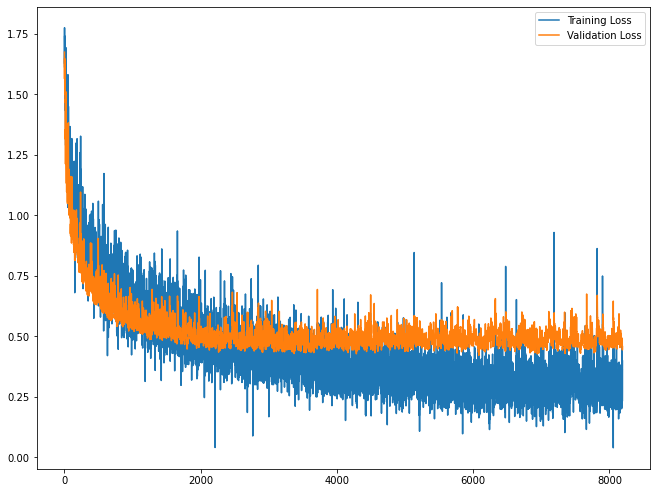

In [ ]:
from IPython.core.pylabtools import figsize
plt.figure(figsize = (11,8.5))
plt.plot(tlossList, label = "Training Loss")
plt.plot(vlossList, label = "Validation Loss")
plt.legend()
plt.show()

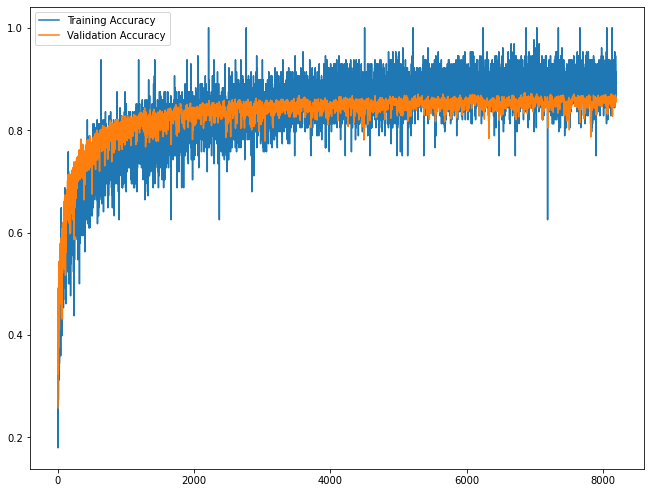

In [ ]:

plt.figure(figsize = (11,8.5))
plt.plot(trAcc, label = "Training Accuracy")
plt.plot(valAcc, label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Save model pth to to PATH

PATH = '/content/drive/My Drive/Projects/Kaggle Intel Dataset/Intnet_0.87_104_128_0.01_0.001.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# Loading validloader in variables for use in inference in training loop in next cell
testloader = DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=False, num_workers=0)
c = 0
inp2 = 0
lab2 = 0
for id, d in enumerate(testloader):
  inp2 = d['image'].float().to(device=device)
  lab2 = d['label'].type(torch.LongTensor).to(device=device)

Checking accuracy on Testing Set

In [ ]:
# Evaluation for test data

# Load
model = net.cuda()
model.eval()

with torch.no_grad():
  out = model(inp2)

a = torch.argmax(out, dim=1)
b = np.mean(np.array((a==lab2).cpu()))
print("Test Accuracy: ",b,"Correctly Classified Images: ",len(test_data)*b,"Incorrectly Classified Images: ",len(test_data)*(1-b) )

Test Accuracy:  0.8656866020715002 Correctly Classified Images:  2591.0 Incorrectly Classified Images:  402.0


## Visualizing Failure Cases

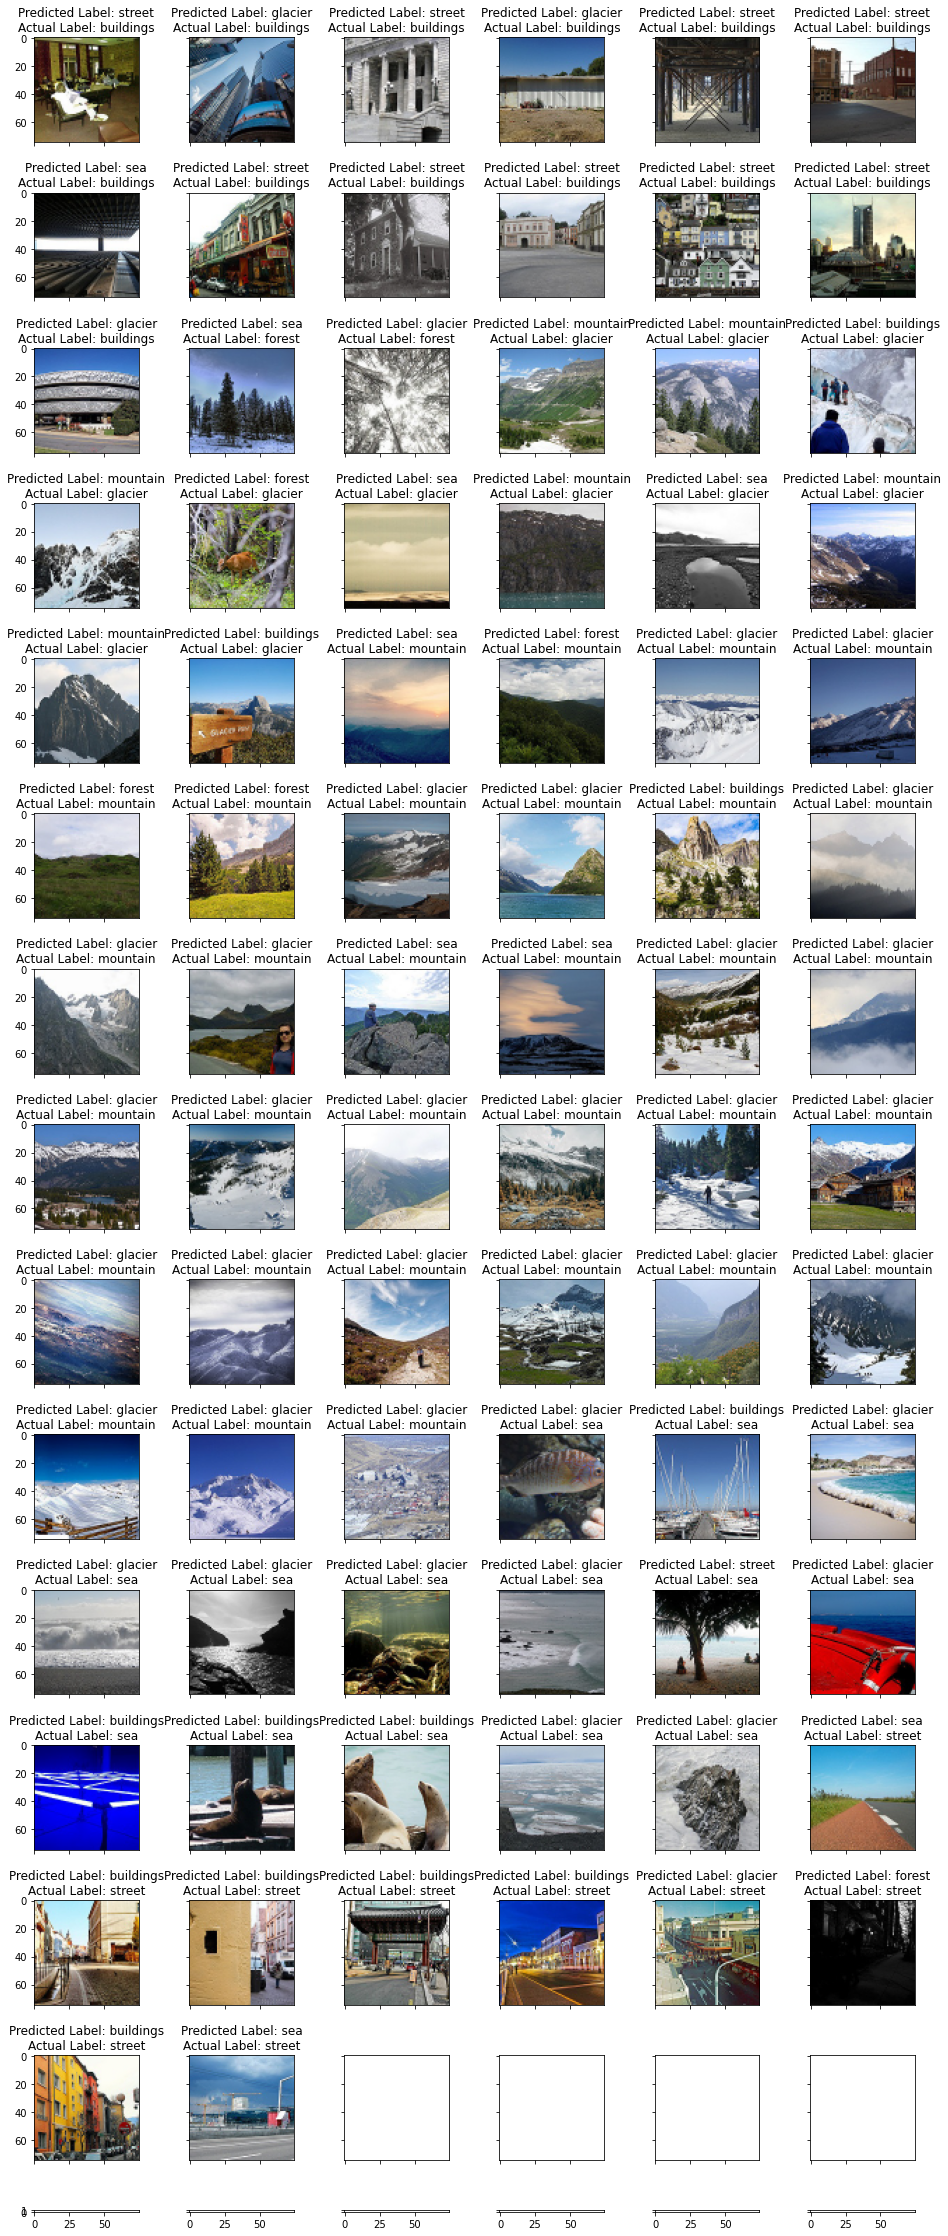

In [ ]:
from pandas.core.algorithms import diff
# Reference:  https://stackoverflow.com/questions/40846492/how-to-add-text-to-each-image-using-imagegrid

from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(1, (64., 40.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(15, 6),
                 axes_pad=0.7,
                 )

listInp = list(inp2)
listLab = lab2.cpu().numpy()

diffList = list(a.cpu().numpy() - lab2.cpu().numpy())
predList = list(a.cpu().numpy())

arList, pL, aL = [], [], []

labdict = {0: "buildings", 1:"forest", 2: "glacier", 3: "mountain", 4: "sea", 5: "street"}

#print(len(diffList))
#print(set(diffList))

ct = 0
with torch.no_grad():
    for i in range(len(diffList)):
      if diffList[i] == 0:
        continue
      else:
        ct = ct + 1

        #plt.show()
        #grid[c].set_title("Predicted Label: "+ str(predList[i]) + "\n" + "Actual Label: " + str(listLab[i]), fontdict=None, loc='center', color = "k")
        #grid[c].imshow(im)
        if ct%5 == 0:
          npimg = listInp[i].cpu().numpy()
          im = np.transpose(npimg, (1, 2, 0))
          im = im.astype('uint8')
          
          arList.append(im)
          pL.append(predList[i])
          aL.append(listLab[i])
        #display(image)
        #print("Predicted Label: ", predList[i])
        #print("Actual Label: ",listLab[i])

c=0
for axes in grid:
    axes.set_title("Predicted Label: "+ str(labdict[pL[c]]) + "\n" + "Actual Label: " + str(labdict[aL[c]]), fontdict=None, loc='center', color = "k")
    axes.imshow(arList[c])
    c+=1
    #print("c",c)
    if c == len(pL):
      break
plt.show()


## Generating Classification Metrics

In [ ]:
test_labels = np.array(lab2.cpu())
test_predictions = np.array(a.cpu())

In [ ]:
pip install pretty-confusion-matrix

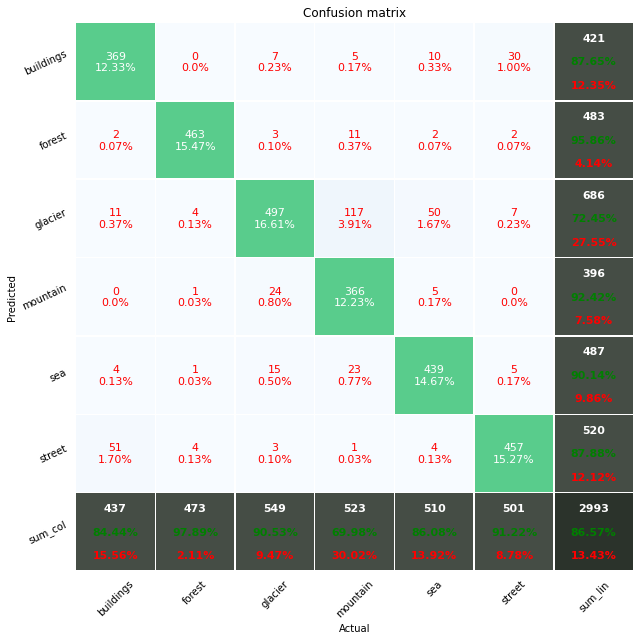

In [ ]:
# Confusion Matrix

from pretty_confusion_matrix import pp_matrix_from_data

pp_matrix_from_data(test_labels, test_predictions, cmap='Blues', columns = ['buildings','forest','glacier', 'mountain', 'sea', 'street'])


In [ ]:
from sklearn.metrics import classification_report

target_names =['buildings','forest','glacier', 'mountain', 'sea', 'street']
print(classification_report(test_labels, test_predictions, target_names=target_names))


              precision    recall  f1-score   support

   buildings       0.88      0.84      0.86       437
      forest       0.96      0.98      0.97       473
     glacier       0.72      0.91      0.80       549
    mountain       0.92      0.70      0.80       523
         sea       0.90      0.86      0.88       510
      street       0.88      0.91      0.90       501

    accuracy                           0.87      2993
   macro avg       0.88      0.87      0.87      2993
weighted avg       0.87      0.87      0.87      2993



References:
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://discuss.pytorch.org/t/changing-transforms-after-creating-a-dataset/64929/6
3. Karen Simonyan, & Andrew Zisserman. (2015). Very Deep Convolutional Networks for Large-Scale Image Recognition. 
4. Sergey Ioffe, & Christian Szegedy. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.
5. https://cs231n.github.io/neural-networks-3/#sgd
6. https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
7. https://stackoverflow.com/questions/40846492/how-to-add-text-to-each-image-using-imagegrid 
8. https://stackoverflow.com/questions/40846492/how-to-add-text-to-each-image-using-imagegrid  
